**Солуянова Наталия, ПМ-1841**

# Содержание
_______________

<p>1. <a href="#b"><font size='4'>Библиотеки и подготовка данных</font></a></p>
<p>2. <a href="#b1"><font size='4'>Анализ данных</font></a></p>
<p>3. <a href="#b2"><font size='4'>Отбор признаков</font></a></p>
<p>3. <a href="#b3"><font size='4'>Модели</font></a></p>
<ul>

<p><a name="b"></a></p>
# 1. Библиотеки и подготовка данных

In [106]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import warnings
import string
import math

import time

warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20, 8)

In [107]:
df = pd.read_csv('features.csv', sep=',')  # features
dt = pd.read_csv('tracks.csv', sep=',')  # tracks
dt = dt.dropna(subset=['album.2'])  # убрали песни без года выпуска

for i in range(2,70295):
    try:
        dt['album.2'][i] = dt['album.2'][i][:4]  # оставим только год
    except:
        i += 1

# удаляем ненужное
del dt['album']
del dt['album.1']
del dt['album.3']
del dt['album.4']
del dt['album.5']
del dt['album.6']
del dt['album.7']
del dt['album.8']
del dt['album.9']
del dt['album.10']
del dt['album.11']
del dt['album.12']
del dt['artist']
del dt['artist.1']
del dt['artist.2']
del dt['artist.3']
del dt['artist.4']
del dt['artist.5']
del dt['artist.6']
del dt['artist.7']
del dt['artist.9']
del dt['artist.11']
del dt['artist.12']
del dt['artist.13']
del dt['artist.14']
del dt['artist.15']
del dt['artist.16']
del dt['set']
del dt['track']
del dt['track.1']
del dt['track.2']
del dt['track.3']
del dt['track.4']
del dt['track.5']
del dt['track.6']
del dt['track.8']
del dt['track.9']
del dt['track.10']
del dt['track.11']
del dt['track.12']
del dt['track.13']
del dt['track.15']
del dt['track.16']
del dt['track.17']
del dt['track.18']
del dt['track.19']

cols = dt.columns.tolist()
cols1 = ['Unnamed: 0', 'album.2', 'artist.8', 'artist.10', 'set.1', 'track.14', 'track.7']  # меняем порядок столбцов
dt = dt[cols1]
df = df[df["feature"] != 'number'] # убираем лишнюю строчку
dt.loc[0][0] = 'statistics'  # меняем значение ячейки, чтобы было такое же, как в df
dt.rename(columns={'Unnamed: 0':'feature'}, inplace=True) #  меняем имя, чтобы было как в dt
ft = pd.merge(df, dt, on='feature', how='outer')  # склеиваем два датафрейма по столбцу feature с track_id
ftnames = [ft.columns[i] for i in range(525)]  # имена столбцов
ft = ft.dropna(subset=['track.7'])  # оставляем только те песни, где указан жанр
ft = ft.dropna(subset=['zcr'])  # оставляем только те песни, у которых собраны показатели

# пусть широта, долгота и подвыборка пока не нужны
del ft['artist.8']
del ft['artist.10']
del ft['set.1']

ftnames1 = [ft.columns[i] for i in range(522)]
colnames1 = ft.columns

<p><a name="b1"></a></p>
# 2. Анализ данных

In [108]:
interest = [i for i in range(1,522)]  # интересующие нас столбцы - все, кроме первого с track_id
interestnames = [colnames1[i] for i in interest]

ft1 = ft[interestnames].loc[2:]  # убрали вторую строку заголовка
ft1 = pd.DataFrame([pd.to_numeric(ft1[i], errors='coerce') for i in interestnames[:-1]]).transpose()
ft1[interestnames[-1]] = ft[interestnames[-1]] #  значения таргета не меняются
ft1['track.7'].value_counts()

Rock              7566
Experimental      6726
Electronic        5095
Hip-Hop           2243
Folk              1308
Pop               1065
Instrumental      1016
International      629
Classical          542
Spoken             300
Jazz               249
Soul-RnB           112
Country             52
Blues               41
Easy Listening      16
Name: track.7, dtype: int64

<p><a name="b2"></a></p>
# 3. Отбор признаков

In [109]:
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import VarianceThreshold

from sklearn.svm import LinearSVC

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [110]:
le = LabelEncoder()
le.fit(ft1['track.7']);
le.transform(ft1['track.7'])
ft1['track.7'] = le.transform(ft1['track.7'])

In [111]:
def corr_df_abs(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)  # число итераций
    drop_cols = []  # будущий список названий удаляемых столбцов

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j + 1), (i + 1):(i + 2)]
            col = item.columns
            row = item.index
            val = item.values
            if val >= abs(corr_val):
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)  # добавляем номера итераций 

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        df = x.drop(col, axis=1)

    return df

corr_df_abs(ft1[interestnames],0.5)

chroma_cens.9 | chroma_cens | 0.97
chroma_cens.9 | chroma_cens.1 | 0.97
chroma_cens.10 | chroma_cens | 0.95
chroma_cens.10 | chroma_cens.1 | 0.96
chroma_cens.11 | chroma_cens | 0.97
chroma_cens.11 | chroma_cens.1 | 0.97
chroma_cens.11 | chroma_cens.9 | 0.96
chroma_cens.35 | chroma_cens.24 | 0.5
chroma_cens.36 | chroma_cens.24 | 0.97
chroma_cens.36 | chroma_cens.25 | 0.56
chroma_cens.37 | chroma_cens.24 | 0.56
chroma_cens.37 | chroma_cens.25 | 0.97
chroma_cens.37 | chroma_cens.26 | 0.61
chroma_cens.38 | chroma_cens.25 | 0.6
chroma_cens.38 | chroma_cens.26 | 0.97
chroma_cens.38 | chroma_cens.27 | 0.59
chroma_cens.39 | chroma_cens.26 | 0.59
chroma_cens.39 | chroma_cens.27 | 0.97
chroma_cens.39 | chroma_cens.28 | 0.57
chroma_cens.40 | chroma_cens.27 | 0.57
chroma_cens.40 | chroma_cens.28 | 0.97
chroma_cens.40 | chroma_cens.29 | 0.66
chroma_cens.41 | chroma_cens.28 | 0.66
chroma_cens.41 | chroma_cens.29 | 0.97
chroma_cens.42 | chroma_cens.30 | 0.97
chroma_cens.42 | chroma_cens.31 | 0.63
chr

chroma_cqt.39 | chroma_cqt.26 | 0.69
chroma_cqt.39 | chroma_cqt.27 | 0.98
chroma_cqt.39 | chroma_cqt.28 | 0.69
chroma_cqt.40 | chroma_cens.27 | 0.58
chroma_cqt.40 | chroma_cens.28 | 0.92
chroma_cqt.40 | chroma_cens.29 | 0.65
chroma_cqt.40 | chroma_cens.39 | 0.58
chroma_cqt.40 | chroma_cens.40 | 0.92
chroma_cqt.40 | chroma_cens.41 | 0.66
chroma_cqt.40 | chroma_cqt.27 | 0.69
chroma_cqt.40 | chroma_cqt.28 | 0.98
chroma_cqt.40 | chroma_cqt.29 | 0.72
chroma_cqt.41 | chroma_cens.28 | 0.62
chroma_cqt.41 | chroma_cens.29 | 0.9
chroma_cqt.41 | chroma_cens.30 | 0.5
chroma_cqt.41 | chroma_cens.40 | 0.63
chroma_cqt.41 | chroma_cens.41 | 0.9
chroma_cqt.41 | chroma_cens.42 | 0.51
chroma_cqt.41 | chroma_cqt.28 | 0.74
chroma_cqt.41 | chroma_cqt.29 | 0.98
chroma_cqt.41 | chroma_cqt.30 | 0.67
chroma_cqt.42 | chroma_cens.29 | 0.52
chroma_cqt.42 | chroma_cens.30 | 0.89
chroma_cqt.42 | chroma_cens.31 | 0.57
chroma_cqt.42 | chroma_cens.41 | 0.53
chroma_cqt.42 | chroma_cens.42 | 0.9
chroma_cqt.42 | chroma_ce

chroma_cqt.76 | chroma_cens.76 | 0.78
chroma_cqt.77 | chroma_cens.17 | 0.59
chroma_cqt.77 | chroma_cens.77 | 0.77
chroma_cqt.78 | chroma_cens.18 | 0.58
chroma_cqt.78 | chroma_cens.78 | 0.73
chroma_cqt.79 | chroma_cens.19 | 0.6
chroma_cqt.79 | chroma_cens.79 | 0.8
chroma_cqt.80 | chroma_cens.20 | 0.55
chroma_cqt.80 | chroma_cens.80 | 0.73
chroma_cqt.80 | chroma_cqt.73 | 0.51
chroma_cqt.80 | chroma_cqt.75 | 0.51
chroma_cqt.81 | chroma_cens.21 | 0.63
chroma_cqt.81 | chroma_cens.81 | 0.81
chroma_cqt.82 | chroma_cens.22 | 0.57
chroma_cqt.82 | chroma_cens.82 | 0.74
chroma_cqt.82 | chroma_cqt.75 | 0.5
chroma_cqt.82 | chroma_cqt.80 | 0.5
chroma_cqt.83 | chroma_cens.23 | 0.59
chroma_cqt.83 | chroma_cens.83 | 0.76
chroma_stft | chroma_cens | 0.97
chroma_stft | chroma_cens.1 | 0.98
chroma_stft | chroma_cens.9 | 0.98
chroma_stft | chroma_cens.10 | 0.96
chroma_stft | chroma_cens.11 | 0.97
chroma_stft | chroma_cqt | 0.99
chroma_stft | chroma_cqt.1 | 0.99
chroma_stft | chroma_cqt.9 | 0.92
chroma_stft

chroma_stft.57 | chroma_stft.48 | 0.77
chroma_stft.57 | chroma_stft.49 | 0.74
chroma_stft.57 | chroma_stft.50 | 0.74
chroma_stft.57 | chroma_stft.51 | 0.77
chroma_stft.57 | chroma_stft.52 | 0.79
chroma_stft.57 | chroma_stft.53 | 0.8
chroma_stft.57 | chroma_stft.54 | 0.82
chroma_stft.57 | chroma_stft.55 | 0.86
chroma_stft.58 | chroma_stft.48 | 0.82
chroma_stft.58 | chroma_stft.49 | 0.78
chroma_stft.58 | chroma_stft.50 | 0.76
chroma_stft.58 | chroma_stft.51 | 0.79
chroma_stft.58 | chroma_stft.52 | 0.8
chroma_stft.58 | chroma_stft.53 | 0.8
chroma_stft.58 | chroma_stft.54 | 0.81
chroma_stft.58 | chroma_stft.55 | 0.83
chroma_stft.58 | chroma_stft.56 | 0.86
chroma_stft.59 | chroma_stft.48 | 0.91
chroma_stft.59 | chroma_stft.49 | 0.84
chroma_stft.59 | chroma_stft.50 | 0.81
chroma_stft.59 | chroma_stft.51 | 0.81
chroma_stft.59 | chroma_stft.52 | 0.79
chroma_stft.59 | chroma_stft.53 | 0.78
chroma_stft.59 | chroma_stft.54 | 0.79
chroma_stft.59 | chroma_stft.55 | 0.8
chroma_stft.59 | chroma_stft.

mfcc.70 | mfcc.48 | 0.51
mfcc.70 | mfcc.50 | 0.99
mfcc.70 | mfcc.68 | 0.52
mfcc.71 | mfcc.31 | 0.51
mfcc.71 | mfcc.47 | 0.53
mfcc.71 | mfcc.49 | 0.63
mfcc.71 | mfcc.51 | 0.99
mfcc.71 | mfcc.53 | 0.62
mfcc.71 | mfcc.55 | 0.52
mfcc.71 | mfcc.67 | 0.54
mfcc.71 | mfcc.69 | 0.64
mfcc.72 | mfcc.52 | 0.99
mfcc.72 | mfcc.54 | 0.54
mfcc.73 | mfcc.49 | 0.56
mfcc.73 | mfcc.51 | 0.62
mfcc.73 | mfcc.53 | 0.99
mfcc.73 | mfcc.55 | 0.6
mfcc.73 | mfcc.57 | 0.51
mfcc.73 | mfcc.69 | 0.57
mfcc.73 | mfcc.71 | 0.63
mfcc.74 | mfcc.52 | 0.54
mfcc.74 | mfcc.54 | 0.99
mfcc.74 | mfcc.56 | 0.54
mfcc.74 | mfcc.72 | 0.54
mfcc.75 | mfcc.51 | 0.52
mfcc.75 | mfcc.53 | 0.61
mfcc.75 | mfcc.55 | 0.99
mfcc.75 | mfcc.57 | 0.61
mfcc.75 | mfcc.59 | 0.53
mfcc.75 | mfcc.71 | 0.53
mfcc.75 | mfcc.73 | 0.61
mfcc.76 | mfcc.54 | 0.54
mfcc.76 | mfcc.56 | 0.99
mfcc.76 | mfcc.58 | 0.57
mfcc.76 | mfcc.74 | 0.55
mfcc.77 | mfcc.53 | 0.52
mfcc.77 | mfcc.55 | 0.62
mfcc.77 | mfcc.57 | 0.99
mfcc.77 | mfcc.59 | 0.63
mfcc.77 | mfcc.73 | 0.52
m

spectral_contrast.8 | mfcc.137 | 0.51
spectral_contrast.8 | mfcc.138 | 0.51
spectral_contrast.8 | mfcc.139 | 0.51
spectral_contrast.9 | mfcc.134 | 0.5
spectral_contrast.9 | mfcc.135 | 0.51
spectral_contrast.9 | mfcc.136 | 0.5
spectral_contrast.9 | mfcc.137 | 0.5
spectral_contrast.9 | mfcc.139 | 0.5
spectral_contrast.10 | mfcc.132 | 0.5
spectral_contrast.10 | mfcc.133 | 0.53
spectral_contrast.10 | mfcc.134 | 0.54
spectral_contrast.10 | mfcc.135 | 0.54
spectral_contrast.10 | mfcc.136 | 0.54
spectral_contrast.10 | mfcc.137 | 0.52
spectral_contrast.10 | mfcc.139 | 0.5
spectral_contrast.10 | spectral_contrast.8 | 0.52
spectral_contrast.13 | mfcc.20 | 0.7
spectral_contrast.13 | mfcc.25 | 0.55
spectral_contrast.13 | mfcc.27 | 0.52
spectral_contrast.13 | mfcc.40 | 0.51
spectral_contrast.13 | spectral_bandwidth.2 | 0.51
spectral_contrast.14 | spectral_contrast.7 | 0.53
spectral_contrast.15 | mfcc.134 | 0.52
spectral_contrast.15 | mfcc.135 | 0.55
spectral_contrast.15 | mfcc.136 | 0.56
spectral_c

spectral_rolloff.2 | mfcc.101 | 0.5
spectral_rolloff.2 | spectral_bandwidth.2 | 0.93
spectral_rolloff.2 | spectral_bandwidth.3 | 0.93
spectral_rolloff.2 | spectral_centroid.2 | 0.98
spectral_rolloff.2 | spectral_centroid.3 | 0.95
spectral_rolloff.2 | spectral_centroid.6 | 0.51
spectral_rolloff.2 | spectral_contrast.20 | 0.5
spectral_rolloff.3 | spectral_bandwidth.2 | 0.87
spectral_rolloff.3 | spectral_bandwidth.3 | 0.9
spectral_rolloff.3 | spectral_centroid.2 | 0.94
spectral_rolloff.3 | spectral_centroid.3 | 0.97
spectral_rolloff.4 | spectral_bandwidth.4 | 0.7
spectral_rolloff.4 | spectral_centroid.4 | 0.91
spectral_rolloff.5 | mfcc.1 | 0.51
spectral_rolloff.5 | mfcc.41 | 0.55
spectral_rolloff.5 | mfcc.61 | 0.55
spectral_rolloff.5 | spectral_bandwidth.5 | 0.8
spectral_rolloff.5 | spectral_centroid | 0.71
spectral_rolloff.5 | spectral_centroid.5 | 0.91
spectral_rolloff.5 | spectral_rolloff | 0.66
spectral_rolloff.6 | mfcc.120 | 0.55
spectral_rolloff.6 | mfcc.121 | 0.61
spectral_rolloff.

,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.10,...,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6,album.2,track.14,track.7
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.347792,...,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,2009.0,1293.0,7
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,1.038253,...,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,2009.0,514.0,7
4,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,0.268932,...,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,2009.0,1151.0,7
5,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,4.326824,...,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,2008.0,50135.0,11
11,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,0.123328,...,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,2009.0,943.0,7
12,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,1.020558,...,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899,2009.0,1832.0,12
13,0.915001,-0.643476,-0.460507,-0.530701,-0.364460,-0.226860,-0.060377,-0.267673,-0.063476,-0.414318,...,0.558770,0.147461,0.036686,0.034180,0.003418,0.805020,0.016905,2009.0,1498.0,12
14,1.607191,1.199649,0.745765,1.430835,-0.155455,0.768487,3.005594,2.779431,1.567088,1.118796,...,40.950294,0.619629,0.088439,0.086914,0.000000,3.275552,0.021831,2006.0,1278.0,5
15,1.501403,0.957514,1.276685,0.640389,0.442936,0.845533,0.917440,0.770691,1.787260,1.148651,...,5.126394,0.627441,0.102232,0.099121,0.004883,0.633483,0.034676,2006.0,489.0,5
16,-0.020869,0.432330,0.331278,0.829845,2.625593,2.005660,0.907704,0.748191,1.560385,-0.301457,...,1.157352,0.261230,0.070760,0.066895,0.000977,0.769163,0.030017,2009.0,582.0,6


In [112]:
ft1 = ft[interestnames].loc[2:]  # убрали вторую строку заголовка
ft1 = pd.DataFrame([pd.to_numeric(ft1[i], errors='coerce') for i in interestnames[:-1]]).transpose()
ft1[interestnames[-1]] = ft[interestnames[-1]]  # значения таргета не меняются
le = LabelEncoder()
le.fit(ft1['track.7']);
le.transform(ft1['track.7'])
ft1['track.7'] = le.transform(ft1['track.7'])
ft1

,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,...,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6,album.2,track.14,track.7
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,2009.0,1293.0,7
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,2009.0,514.0,7
4,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,2009.0,1151.0,7
5,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,2008.0,50135.0,11
11,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,2009.0,943.0,7
12,0.978402,0.623572,1.129261,-1.043970,-1.127288,-0.032642,-0.878434,-0.916234,-0.743257,0.609235,...,-0.038451,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899,2009.0,1832.0,12
13,0.915001,-0.643476,-0.460507,-0.530701,-0.364460,-0.226860,-0.060377,-0.267673,-0.063476,0.248518,...,0.558770,0.147461,0.036686,0.034180,0.003418,0.805020,0.016905,2009.0,1498.0,12
14,1.607191,1.199649,0.745765,1.430835,-0.155455,0.768487,3.005594,2.779431,1.567088,2.431861,...,40.950294,0.619629,0.088439,0.086914,0.000000,3.275552,0.021831,2006.0,1278.0,5
15,1.501403,0.957514,1.276685,0.640389,0.442936,0.845533,0.917440,0.770691,1.787260,5.555072,...,5.126394,0.627441,0.102232,0.099121,0.004883,0.633483,0.034676,2006.0,489.0,5
16,-0.020869,0.432330,0.331278,0.829845,2.625593,2.005660,0.907704,0.748191,1.560385,2.565748,...,1.157352,0.261230,0.070760,0.066895,0.000977,0.769163,0.030017,2009.0,582.0,6


In [119]:
# удаление признаков с высокими коэффициентами корреляции
def remove_collinear_features(x, y, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j + 1), (i + 1):(i + 2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= abs(threshold):
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
               
    return x

# удаление признаков с малой дисперсией
def variance_threshold_selector(data, threshold):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# удаление признаков, исходя из важности в случайном лесу
def extra_trees_selector(X, y, nest):
    clf = ExtraTreesClassifier(n_estimators=nest, random_state=42, class_weight='balanced')
    clf = clf.fit(X, y)
    model = SelectFromModel(clf, prefit=True)
    return X[X.columns[model.get_support(indices=True)]]

In [121]:
names = sorted([['Rock',12],
                ['Experimental',5],
                ['Electronic',4],
                ['Hip-Hop',7],
                ['Folk',6],
                ['Pop',11],
                ['Instrumental',8],
                ['International',9],
                ['Classical',1],
                ['Spoken',14],
                ['Jazz',10],
                ['Soul-RnB',13],
                ['Country',2],
                ['Blues',0],
                ['Easy Listening',3]])
names

[['Blues', 0],
 ['Classical', 1],
 ['Country', 2],
 ['Easy Listening', 3],
 ['Electronic', 4],
 ['Experimental', 5],
 ['Folk', 6],
 ['Hip-Hop', 7],
 ['Instrumental', 8],
 ['International', 9],
 ['Jazz', 10],
 ['Pop', 11],
 ['Rock', 12],
 ['Soul-RnB', 13],
 ['Spoken', 14]]

In [122]:
t = ft1.pivot_table(values=['track.14'], index=['album.2'], columns=['track.7'], aggfunc='count', fill_value='')
t

track.14                                                               \
track.7       0    1   2  3    4    5    6    7    8    9   10   11    12  13   
album.2                                                                         
1968.0                                   12                                     
1971.0                                                                  7       
1973.0                                                                  5       
1976.0                               2                       2          9       
1979.0                                                                  4       
1980.0                                                                  2       
1981.0                                                                  6       
1982.0                                                                 19       
1984.0                                                                 11       
1985.0                                                                  8       
1986.0                                                                 10       
1987.0                                                           14             
1990.0                                                                 10       
1991.0                                                                  6       
1992.0                                                                 15       
1993.0                                                                 61       
1994.0                               3                                 17       
1995.0                         15    5                       2         83       
1996.0                               9              5                  29       
1997.0                               6    1        11   11             23       
1998.0                              66                                 15       
1999.0                          5    4    3                            15       
2000.0                              17    1                  3         37       
2001.0                          6   19   12         1        3          3   9   
2002.0                         26   65    4                            23       
2003.0                         27   20    2    1         8  22    9    22  13   
2004.0                         12   80             13                  63   6   
2005.0         3   11          73   74    3         4    5             41   8   
2006.0         8           2  132   77    3         1   15  21    1    86   2   
2007.0             12         146   88    4   45   39   13       25   107       
2008.0             40         193  162   17        27    4   7   18   145       
2009.0         7   16         266  207   69   76    7   12  30   19   331   6   
2010.0            171         630  736  162  190  112   44  37  103   723  13   
2011.0         2   18         618  726  129  278   98  161  42  136  1158   8   
2012.0            182  19     589  778  125  311   34   46  31  120   954   9   
2013.0         5   12   1  6  561  901  128  251   95   31   2  132   868   4   
2014.0                        224  362   83  149   16   62   5   12   319       
2015.0                                                                  2       
2016.0                               7                                          

             
track.7  14  
album.2      
1968.0       
1971.0       
1973.0       
1976.0       
1979.0       
1980.0       
1981.0       
1982.0       
1984.0       
1985.0       
1986.0       
1987.0       
1990.0       
1991.0       
1992.0       
1993.0       
1994.0       
1995.0       
1996.0       
1997.0       
1998.0       
1999.0       
2000.0       
2001.0   23  
2002.0       
2003.0       
2004.0       
2005.0       
2006.0       
2007.0    1  
2008.0       
2009.0   75  
2010.0   17  
2011.0   54  
2012.0   27  
2013.0    8  
2014.0    9  
2015.0       
2016.0

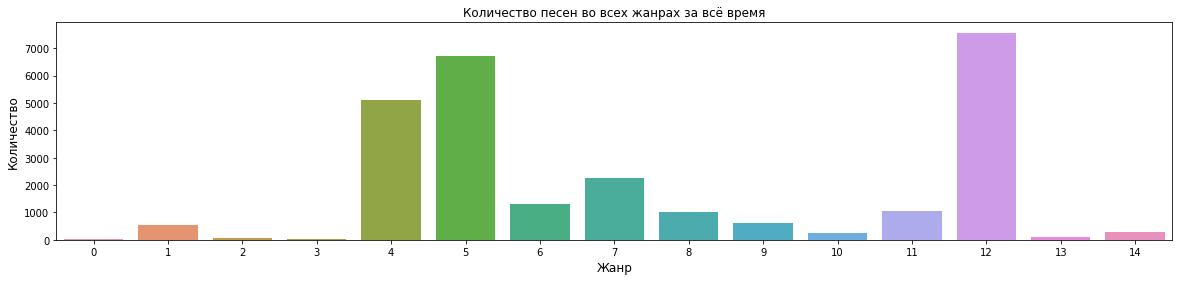

In [12]:
plt.figure(figsize=(20, 4))
sns.countplot(x=ft1['track.7'], data=ft1)
plt.xticks(rotation='horizontal')
plt.ylabel('Количество', fontsize=12)
plt.xlabel('Жанр', fontsize=12)
plt.title('Количество песен во всех жанрах за всё время')
plt.show()

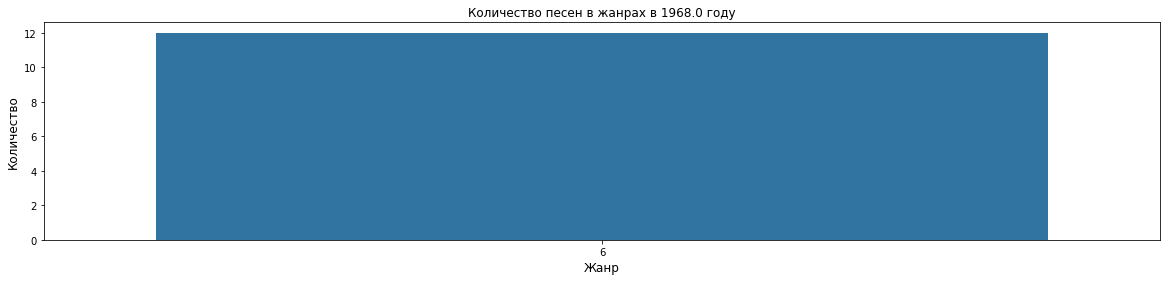

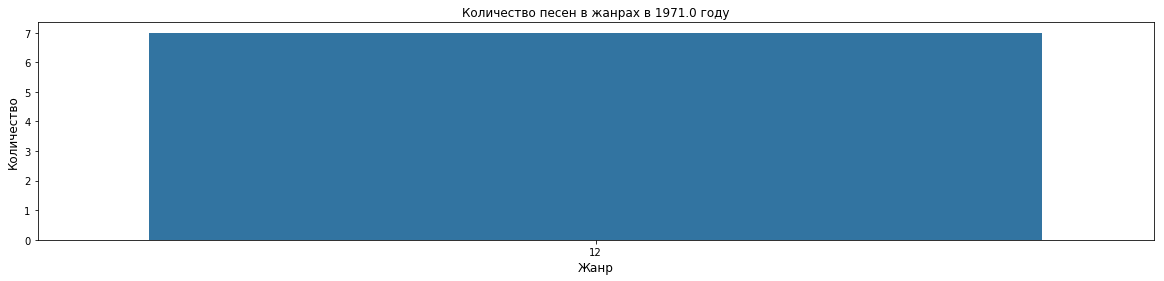

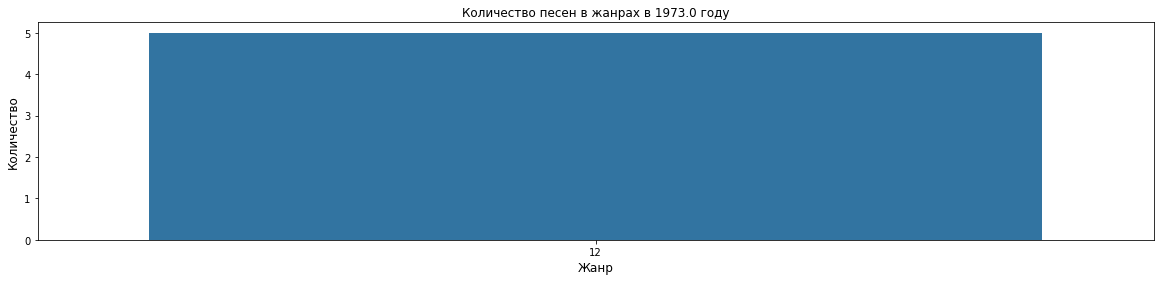

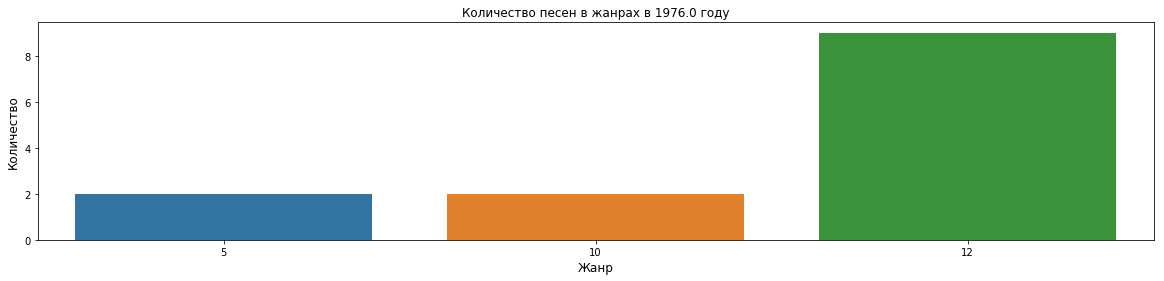

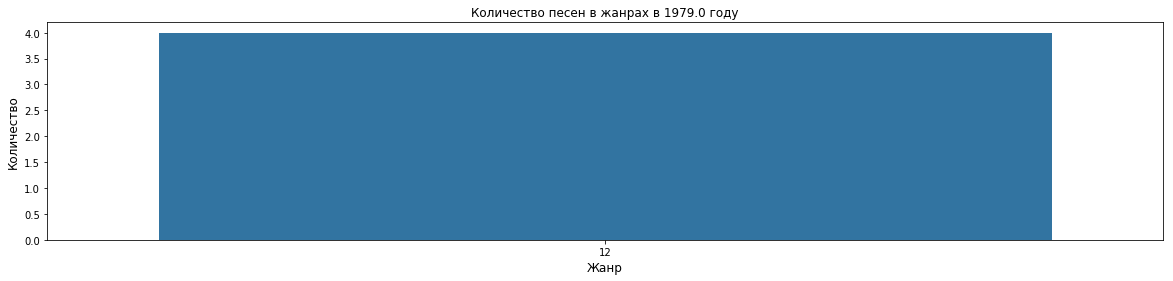

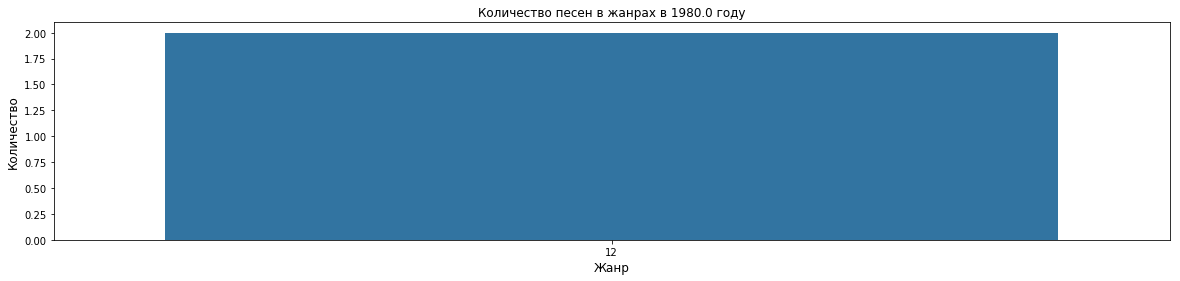

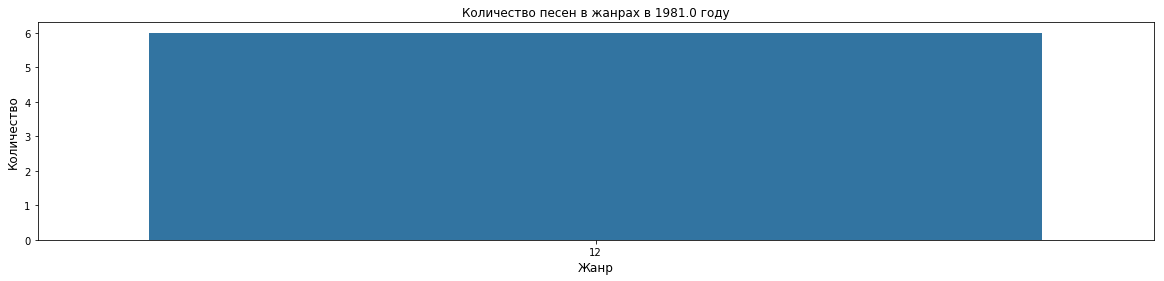

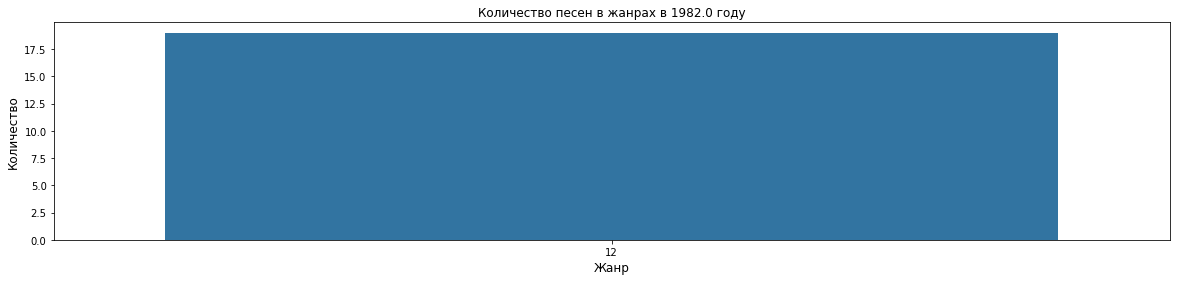

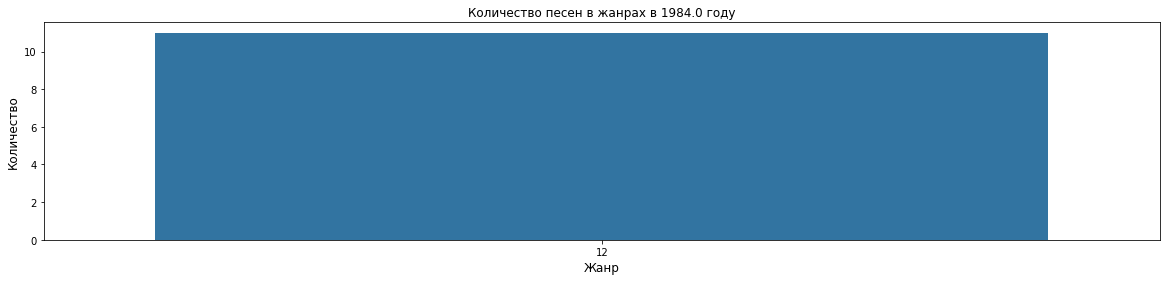

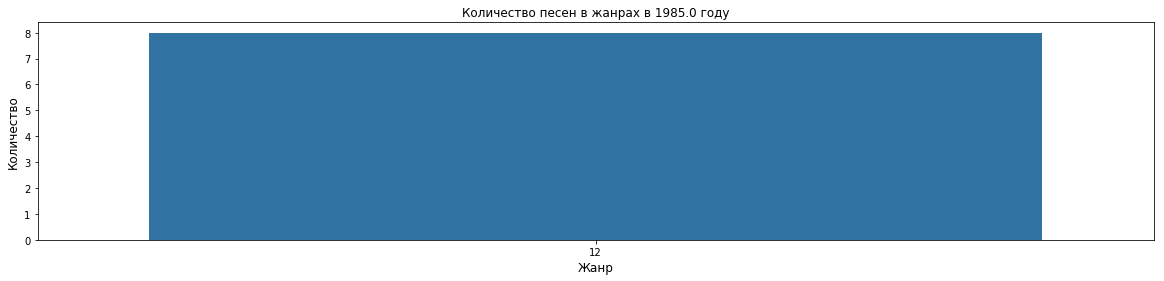

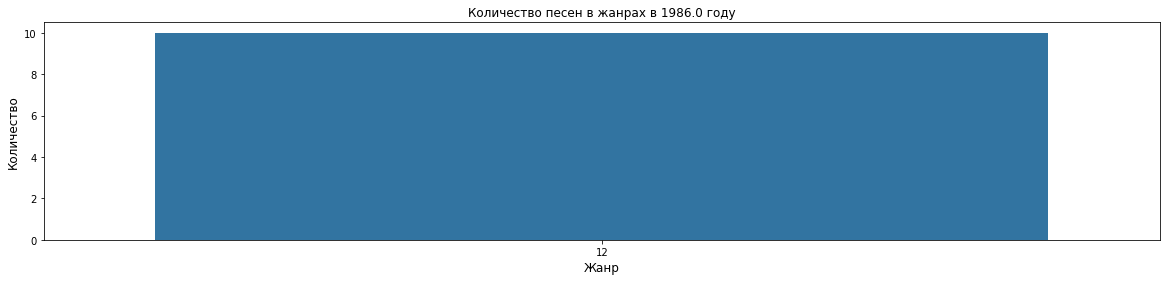

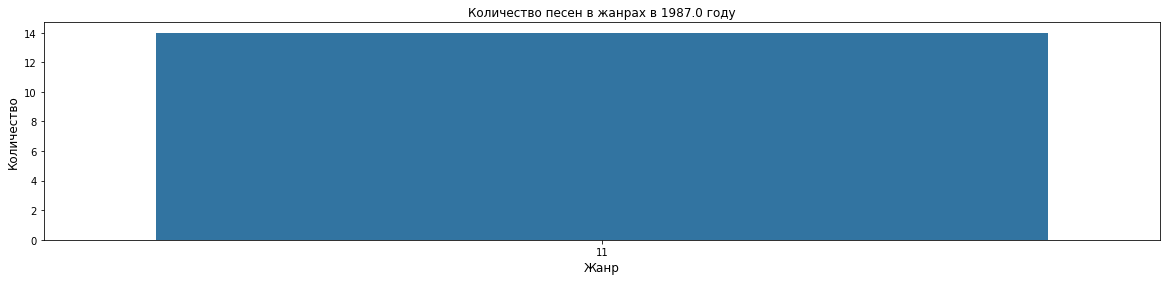

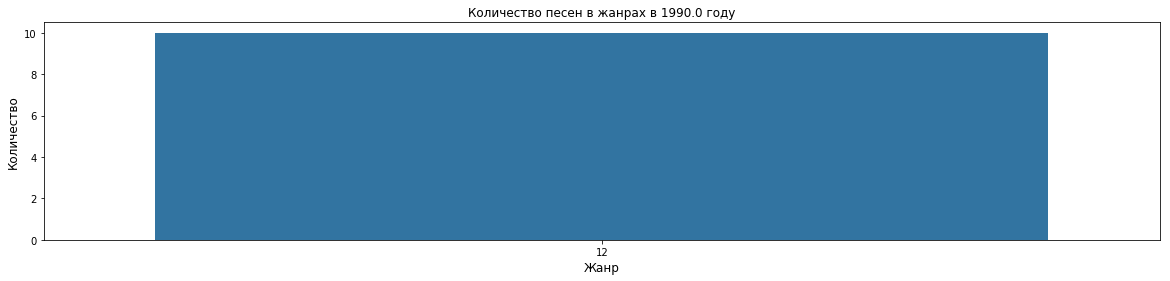

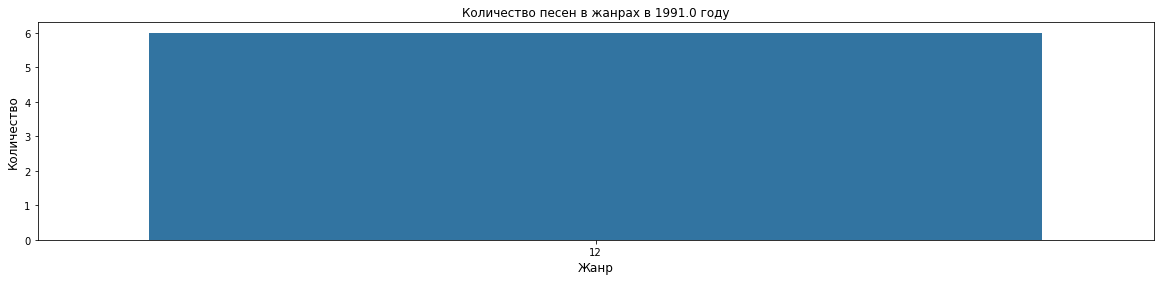

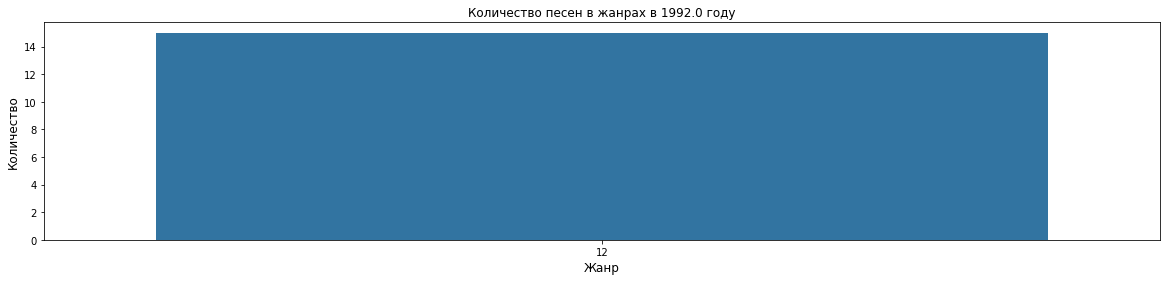

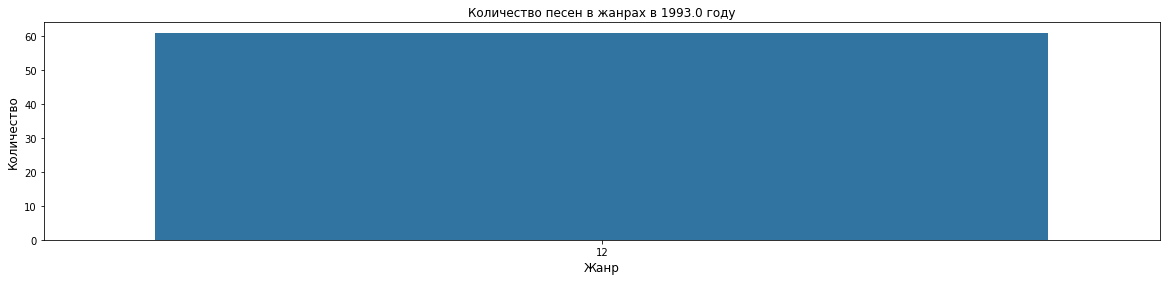

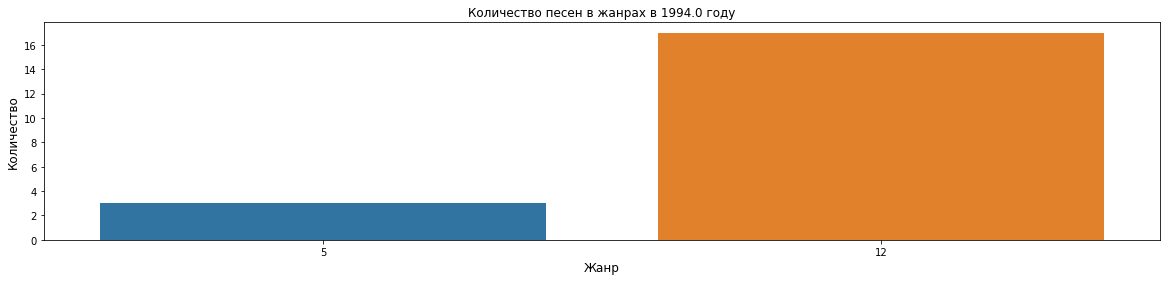

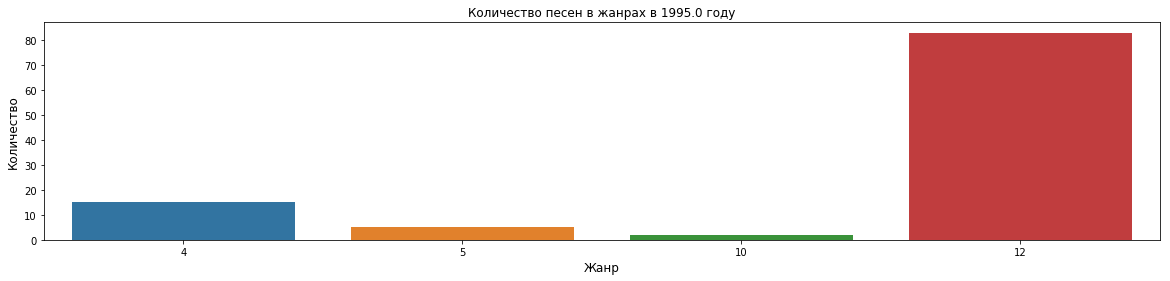

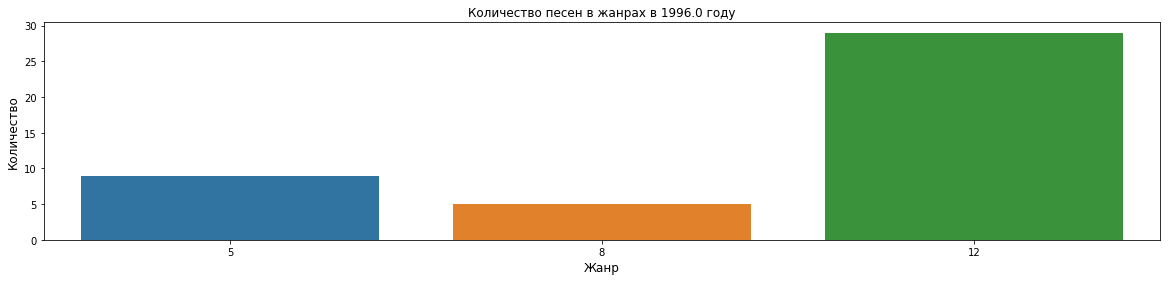

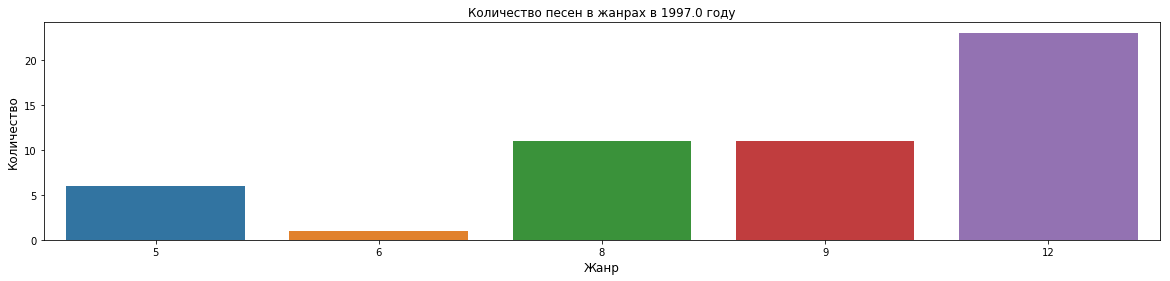

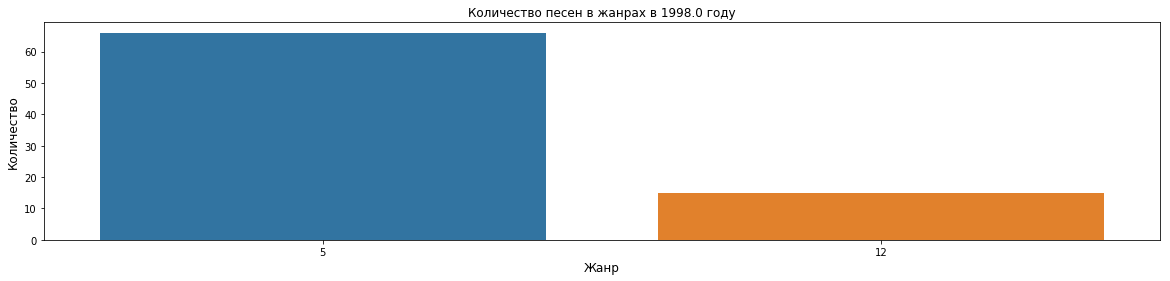

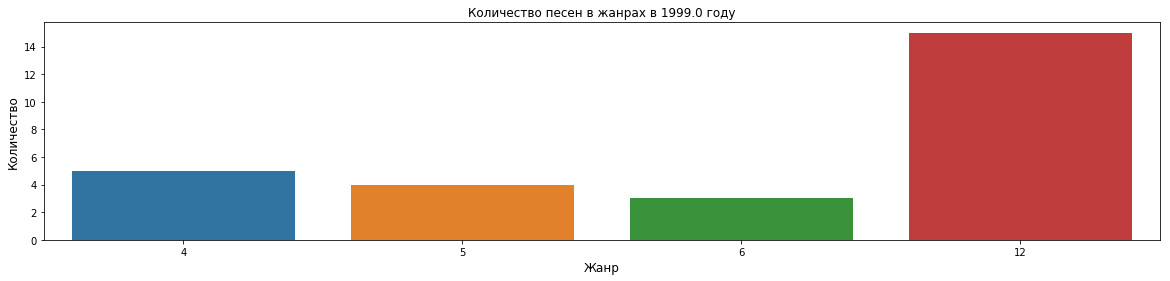

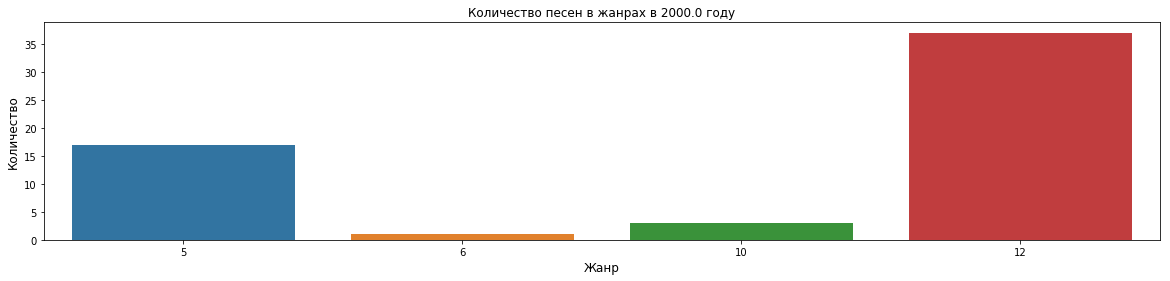

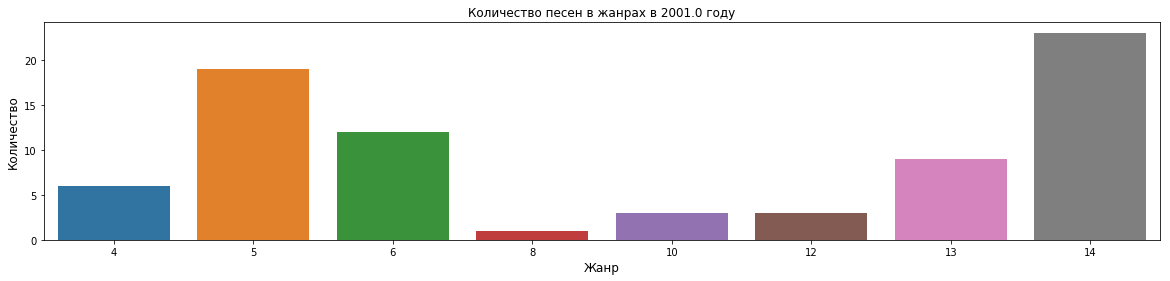

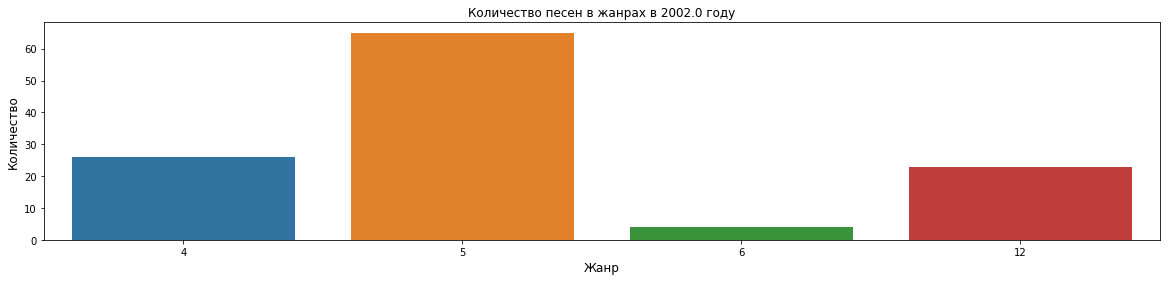

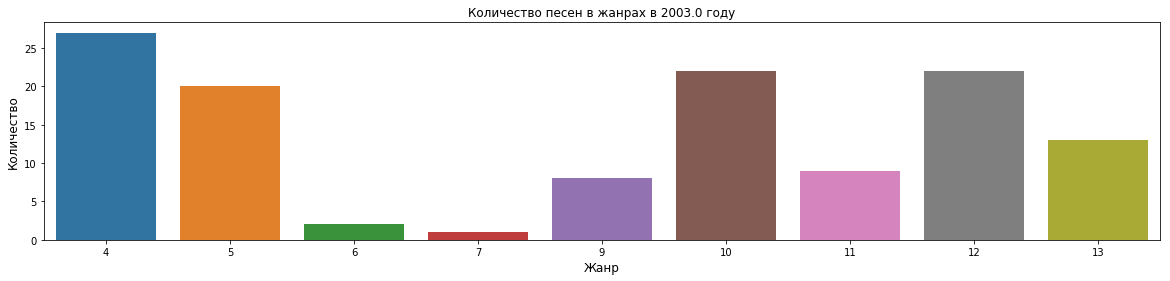

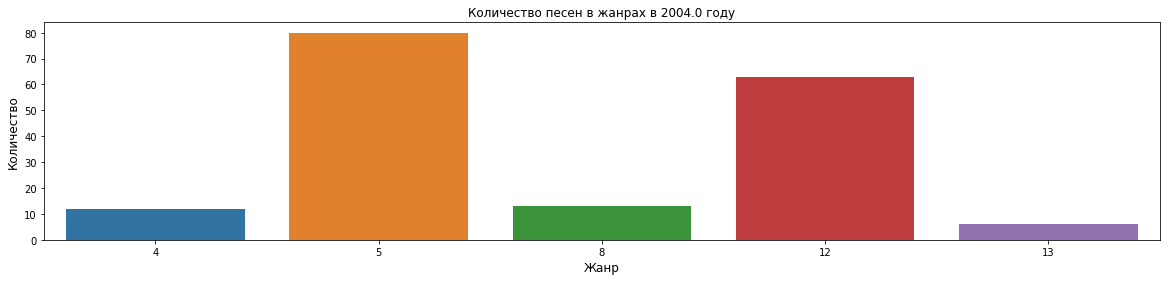

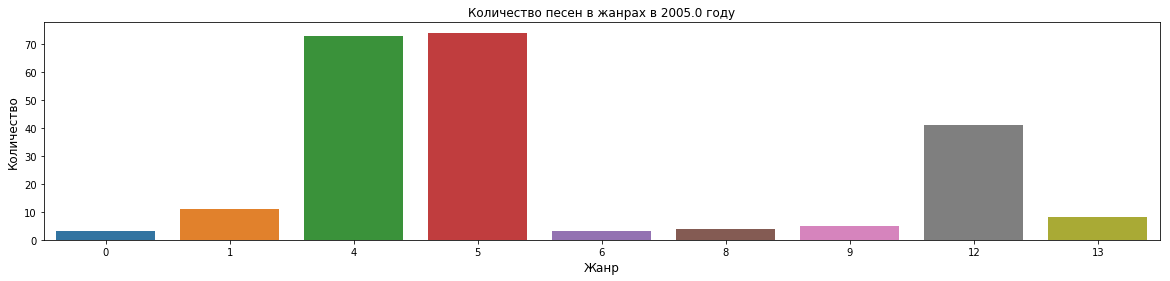

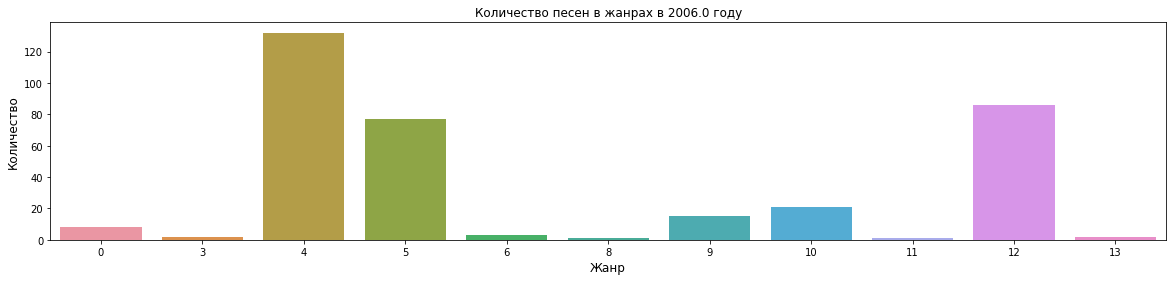

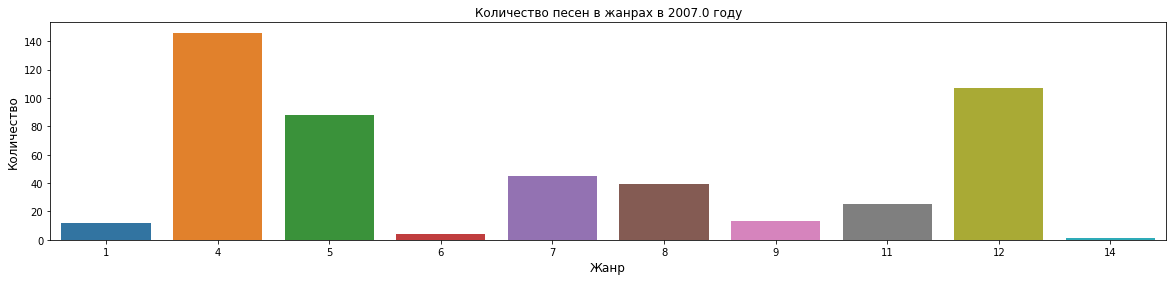

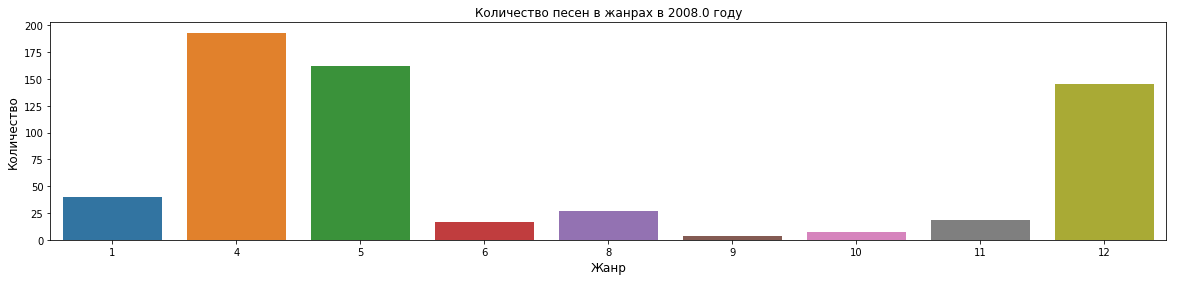

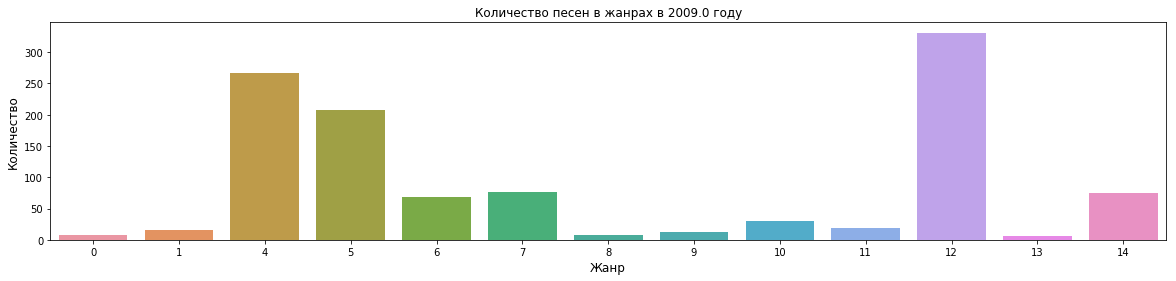

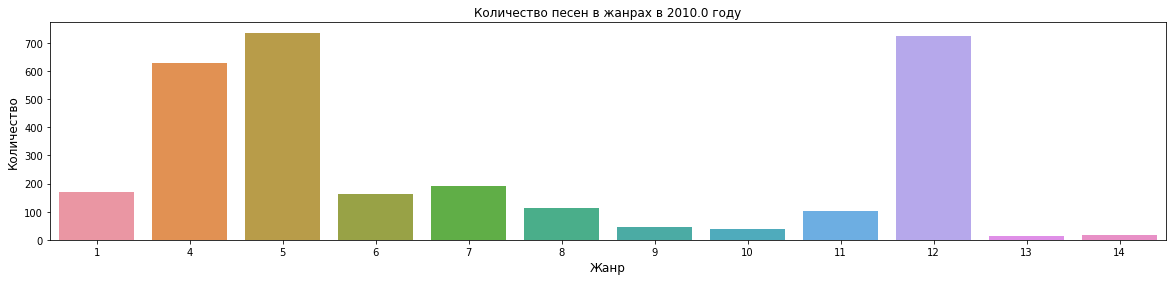

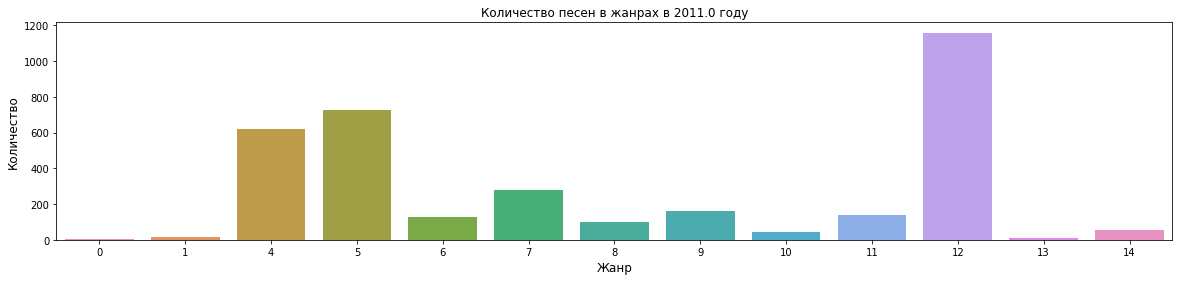

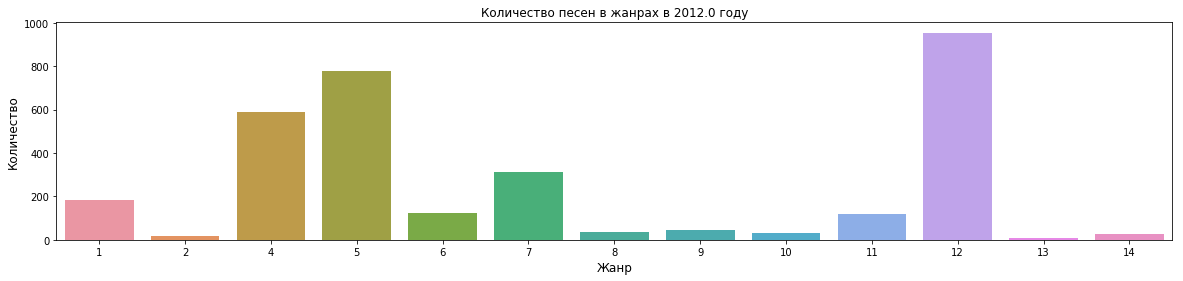

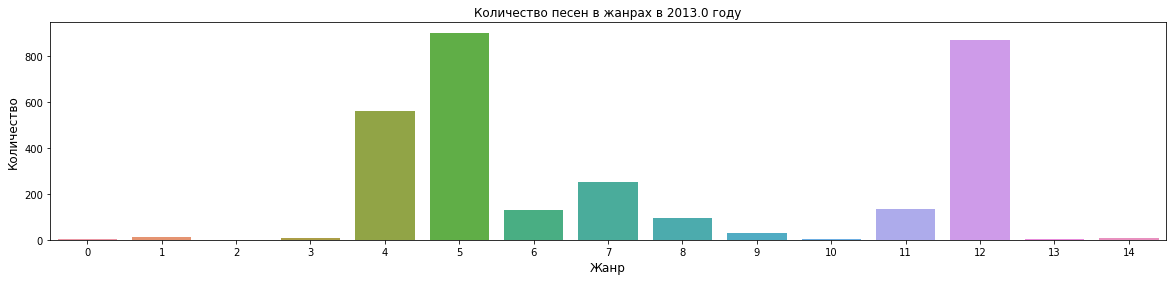

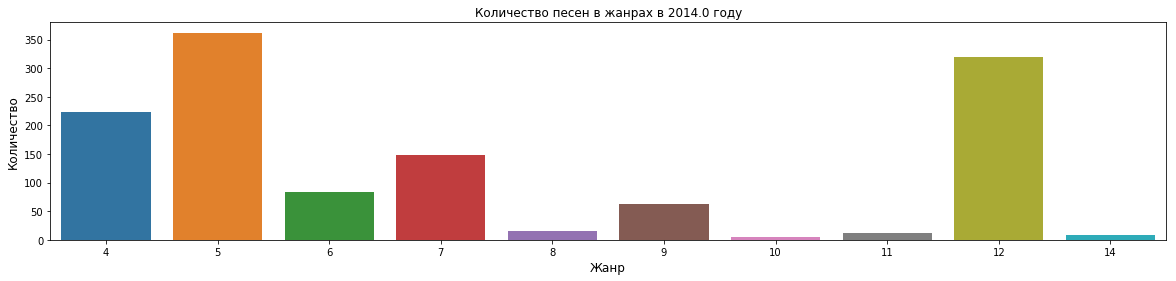

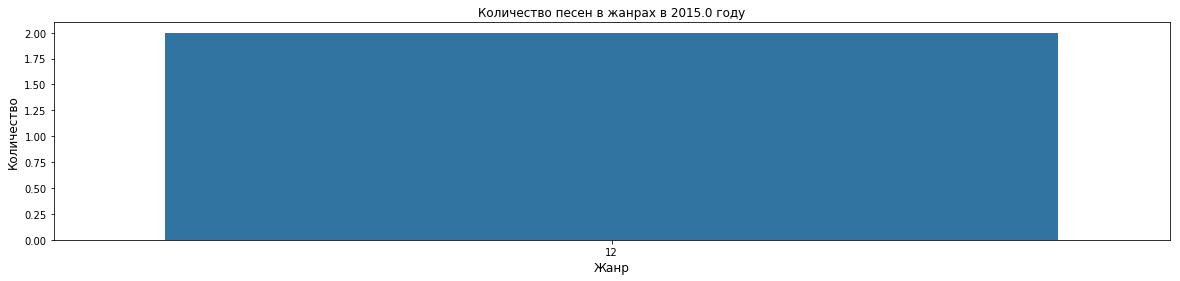

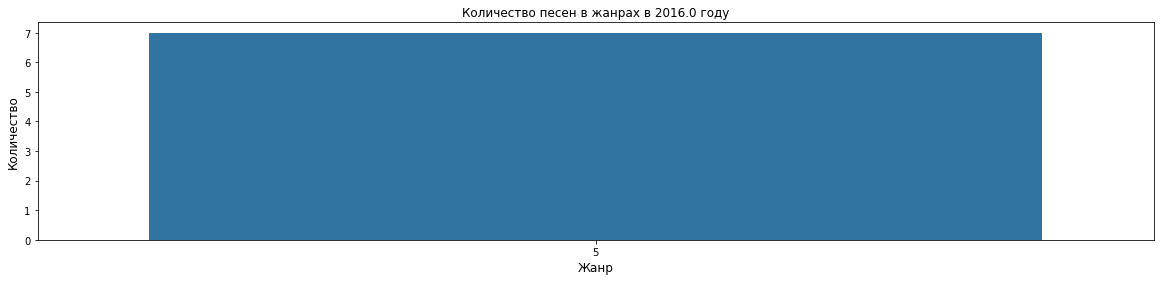

In [14]:
# Жанры по годам
for i in list(t.index):
    plt.figure(figsize=(20, 4))
    sns.countplot(x=ft1[ft1['album.2']==float(i)]['track.7'], data=ft1[ft1['album.2']==float(i)])
    plt.xticks(rotation='horizontal')
    plt.ylabel('Количество', fontsize=12)
    plt.xlabel('Жанр', fontsize=12)
    plt.title('Количество песен в жанрах в %s году'%i)
    plt.show()

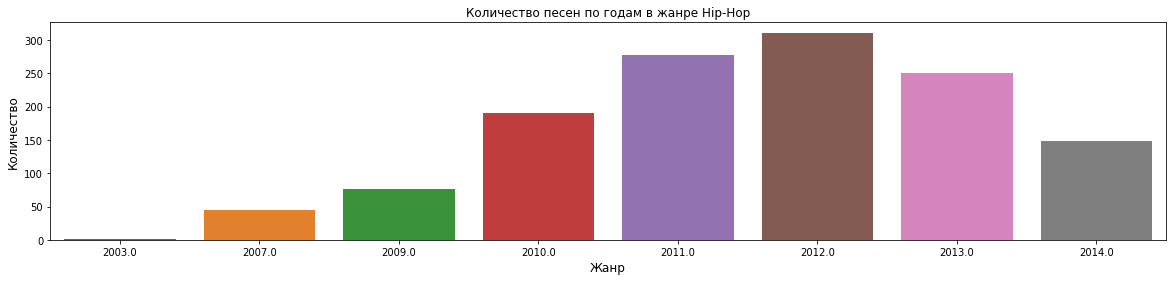

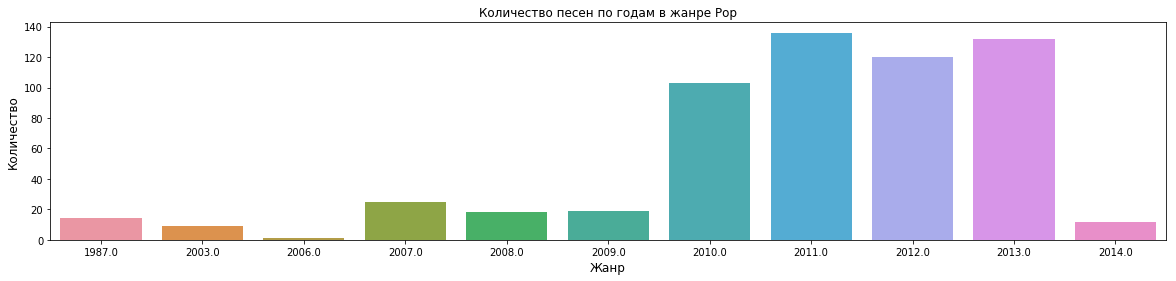

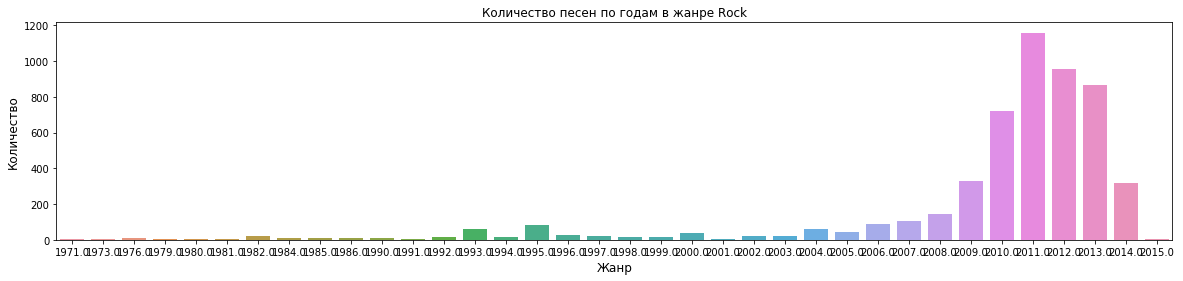

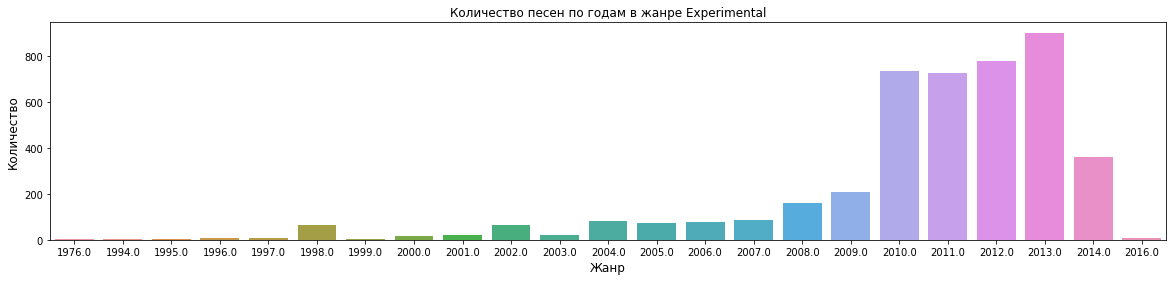

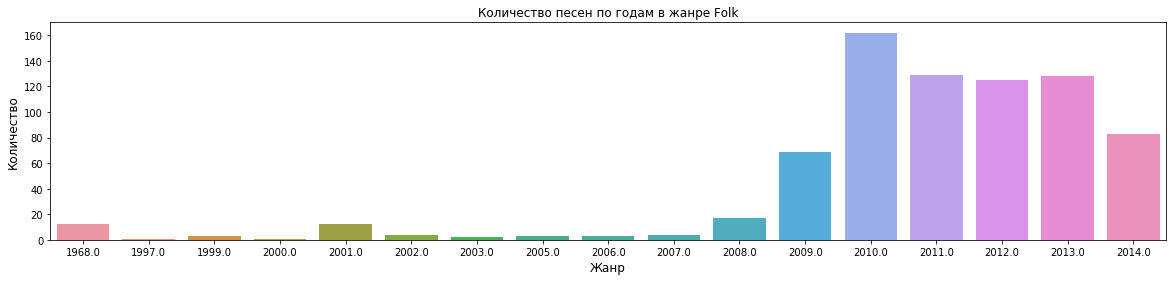

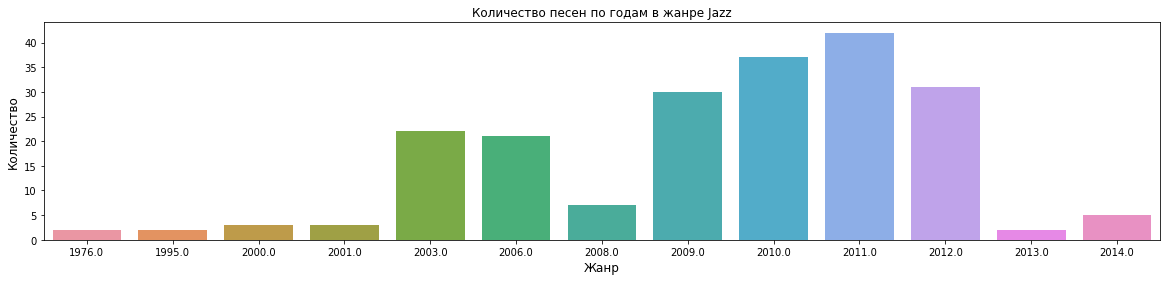

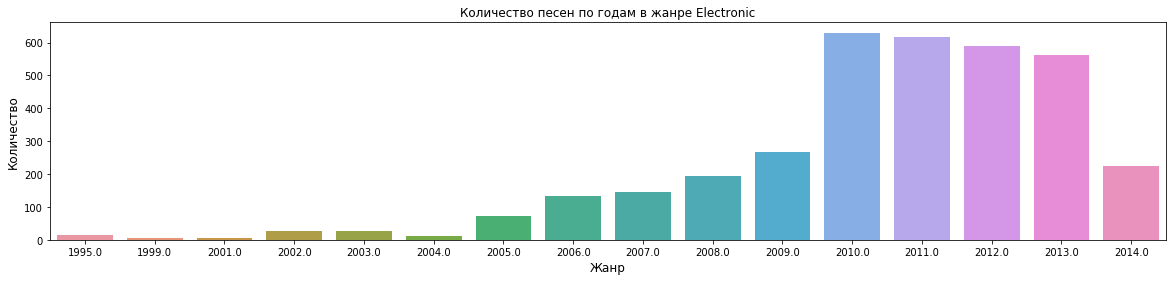

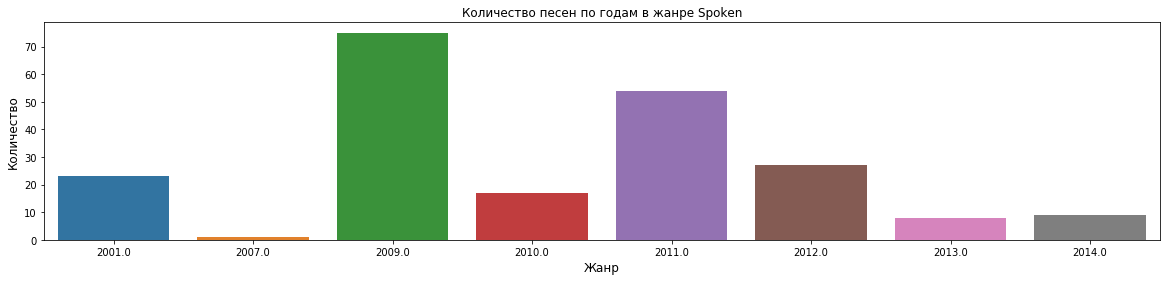

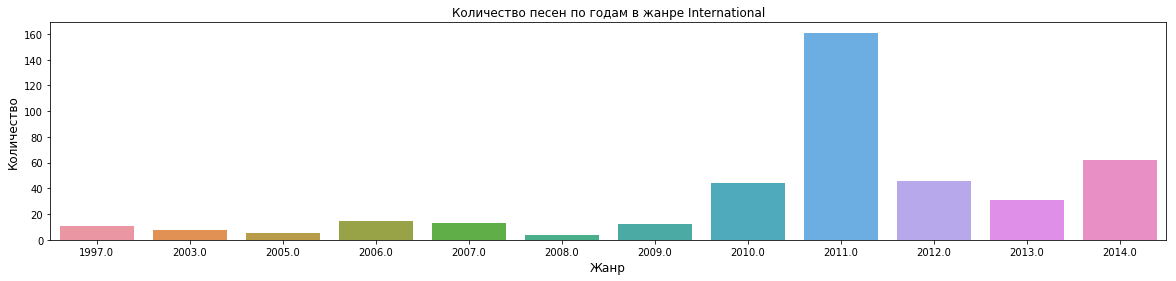

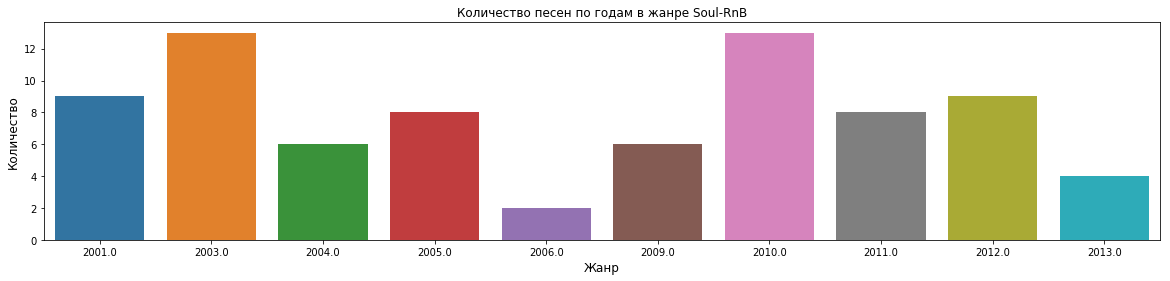

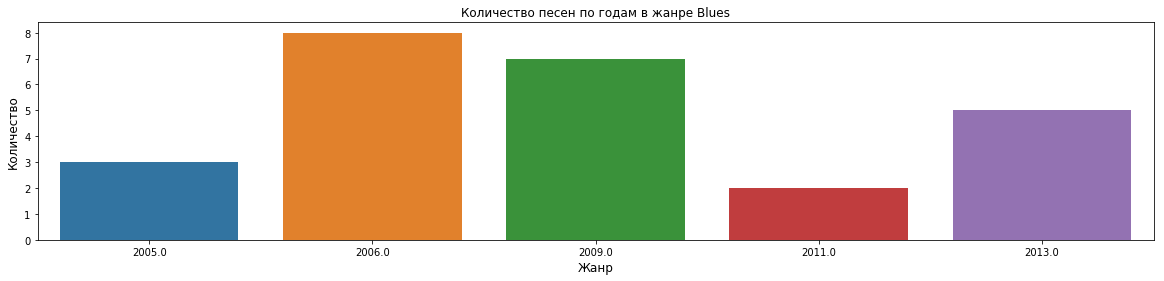

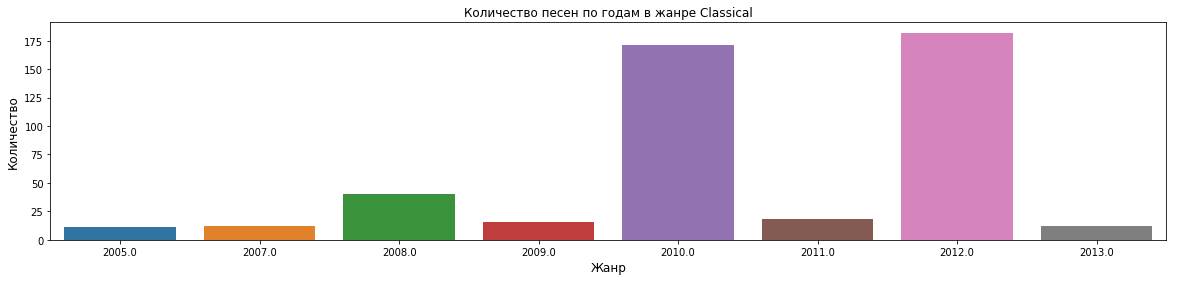

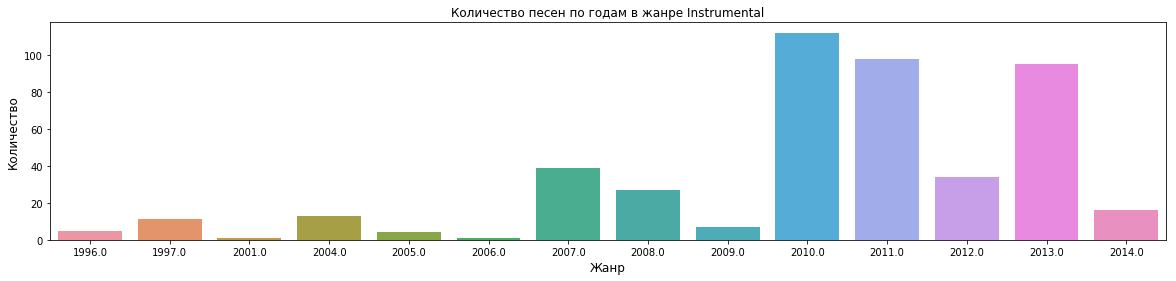

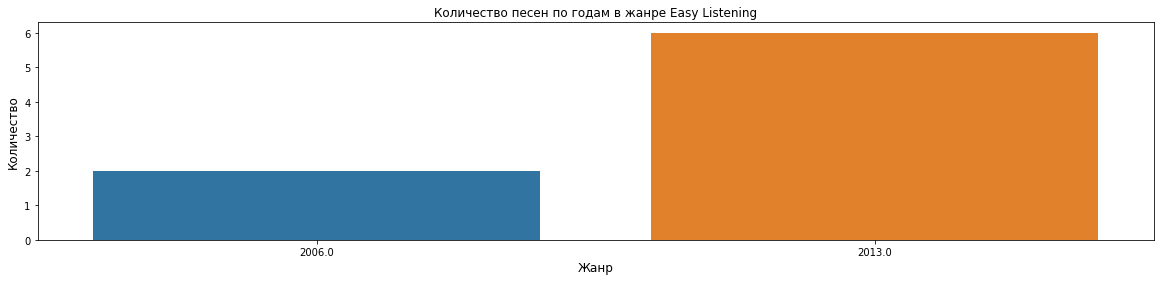

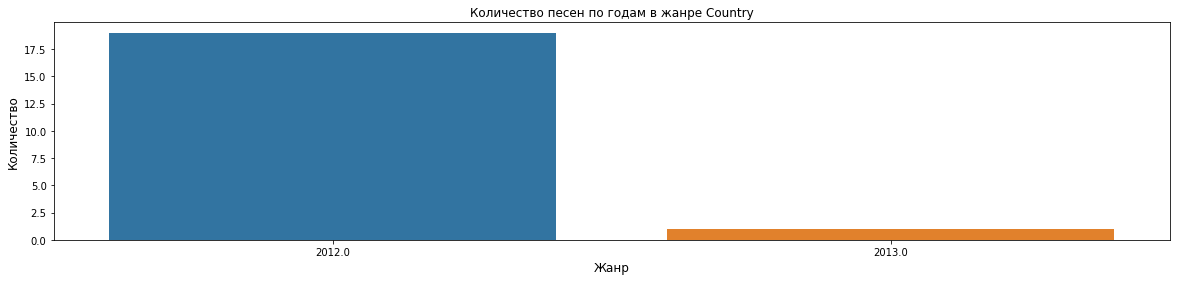

In [15]:
# Года по жанрам
for i in list(ft1['track.7'].unique()):
    plt.figure(figsize=(20, 4))
    sns.countplot(x=ft1[ft1['track.7']==i]['album.2'], data=ft1[ft1['track.7']==i])
    plt.xticks(rotation='horizontal')
    plt.ylabel('Количество', fontsize=12)
    plt.xlabel('Год', fontsize=12)
    plt.title('Количество песен по годам в жанре %s'%names[i][0])
    plt.show()

In [124]:
# сравниваем количество отобранных признаков и время работы
X, y = ft1[interestnames[:-3]], ft1['track.7']
# X_new11 = remove_collinear_features(X,y,0.5)  # (26960, 159) 310.49404800799994 seconds
# X_new12 = remove_collinear_features(X,y,0.6)  # (26960, 231) 321.4249692210001 seconds
# X_new21 = variance_threshold_selector(X, .5 * (1 - .5))  # (26960, 281) 3.0337050810001074 seconds
# X_new22 = variance_threshold_selector(X, .6 * (1 - .6))  # (26960, 281) 0.2549910939999336 seconds
# X_new23 = variance_threshold_selector(X, .7 * (1 - .7))  # (26960, 282) 0.24523688899989793 seconds
# X_new24 = variance_threshold_selector(X, .8 * (1 - .8))  # (26960, 286) 0.2620619290000832 seconds
# X_new25 = variance_threshold_selector(X, .9 * (1 - .9))  # (26960, 300) 0.25380156900018846 seconds
X_new31 = extra_trees_selector(X,y,50)  # (26960, 232) 12.627768252999886 seconds
X_new32 = extra_trees_selector(X,y,100)  # (26960, 229) 24.964343564000046 seconds
# X_new33 = extra_trees_selector(X,y,500)  # (26960, 232) 125.92107139399991 seconds

In [125]:
# метод, похожий на head и tail, но для столбцов
def interv(self, m, n):
    return self.iloc[:, m:n]

pd.DataFrame.interv = interv

In [128]:
X_new31.shape, X_new32.shape

((26960, 232), (26960, 229))

In [126]:
ta = [X_new31,X_new32]
clnames = [list(i.columns) for i in ta]
indx = ['X_new31', 'X_new32']
rest = pd.DataFrame(clnames, index=indx)

In [129]:
rest.interv(20,40)  # разные параметры не сильно влияют на результат

,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
X_new31,chroma_cqt.76,chroma_cqt.77,chroma_cqt.79,chroma_cqt.80,chroma_cqt.81,chroma_cqt.82,chroma_stft.24,chroma_stft.25,chroma_stft.26,chroma_stft.28,chroma_stft.29,chroma_stft.33,chroma_stft.35,chroma_stft.36,chroma_stft.37,chroma_stft.39,chroma_stft.40,chroma_stft.41,chroma_stft.42,chroma_stft.43
X_new32,chroma_cqt.74,chroma_cqt.75,chroma_cqt.76,chroma_cqt.77,chroma_cqt.78,chroma_cqt.79,chroma_cqt.80,chroma_cqt.81,chroma_cqt.82,chroma_stft.24,chroma_stft.25,chroma_stft.26,chroma_stft.28,chroma_stft.29,chroma_stft.35,chroma_stft.36,chroma_stft.37,chroma_stft.38,chroma_stft.40,chroma_stft.41


<p><a name="b3"></a></p>
# 4. Модели

In [1]:
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier

from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          normalize=True):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'f'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

NameError: name 'plt' is not defined

Возьмём 229 признаков, оставленные 100 решающими деревьями.

In [130]:
X_new32['track.7'] = ft1['track.7']
X_new32

,chroma_cens.13,chroma_cens.18,chroma_cens.19,chroma_cens.20,chroma_cens.22,chroma_cens.26,chroma_cens.72,chroma_cens.73,chroma_cens.74,chroma_cens.75,...,tonnetz.39,tonnetz.40,tonnetz.41,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6,track.7
2,0.569344,0.487976,0.497327,0.574435,0.620102,0.236119,0.106365,0.085317,0.092350,0.077237,...,0.054125,0.012226,0.012111,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,7
3,0.584248,0.542833,0.664720,0.511329,0.603398,0.225674,0.081881,0.084639,0.102759,0.090946,...,0.063831,0.014212,0.017740,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,7
4,0.651471,0.497172,0.559755,0.671287,0.551663,0.250737,0.086736,0.125088,0.100257,0.072991,...,0.040730,0.012691,0.014759,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,7
5,0.540411,0.651501,0.516887,0.511479,0.638766,0.240096,0.051912,0.096043,0.056647,0.118345,...,0.074358,0.017952,0.013921,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,11
11,0.596978,0.643284,0.551302,0.566937,0.638279,0.262994,0.100488,0.102908,0.106594,0.090595,...,0.058766,0.016322,0.015819,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,7
12,0.607221,0.701188,0.700575,0.664529,0.585292,0.200146,0.099677,0.092489,0.079689,0.151660,...,0.104279,0.016731,0.020464,0.234863,0.050837,0.050781,0.003418,0.297873,0.024899,12
13,0.638670,0.579559,0.627350,0.499344,0.630017,0.381056,0.080730,0.104979,0.123583,0.090394,...,0.076808,0.017915,0.016706,0.147461,0.036686,0.034180,0.003418,0.805020,0.016905,12
14,0.625258,0.629381,0.624669,0.572818,0.537102,0.291284,0.058072,0.059713,0.057999,0.063619,...,0.041466,0.011149,0.011149,0.619629,0.088439,0.086914,0.000000,3.275552,0.021831,5
15,0.562965,0.613897,0.564842,0.661057,0.616068,0.280715,0.069332,0.072517,0.066916,0.068230,...,0.045315,0.012823,0.012725,0.627441,0.102232,0.099121,0.004883,0.633483,0.034676,5
16,0.689985,0.680192,0.704277,0.630835,0.665178,0.279023,0.129993,0.113875,0.093506,0.090092,...,0.090518,0.017428,0.021490,0.261230,0.070760,0.066895,0.000977,0.769163,0.030017,6


In [172]:
X, y = X_new32.drop('track.7', axis=1), X_new32['track.7']

In [177]:
from sklearn.preprocessing import Imputer, RobustScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                y,
                                                test_size=0.2,
                                                random_state=42,
                                                shuffle=True
                                                )

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42,shuffle=True)

start_time = time.clock()
modelR = RandomForestClassifier(class_weight='balanced',
                                n_estimators=200,
                                max_depth=10,
                                random_state=1)
modelB = BalancedBaggingClassifier(base_estimator=modelR,
                                   n_estimators=200,
                                   random_state=1)

pip_resampled = make_pipeline(Imputer(strategy="mean"),
                              RobustScaler(),
                              modelB)

model = pip_resampled    
model.fit(X_train, y_train)

predictions = model.predict(X_train)
predictionst = model.predict(X_test)
predictionsv = model.predict(X_val)

cnf = confusion_matrix(y_train, predictions)
f1 = f1_score(y_train, predictions, average='weighted')
pr = precision_score(y_train, predictions, average='weighted')
rec = recall_score(y_train, predictions, average='weighted')
# print("Для train: f1-score", f1, "precision", pr, "recall", rec)

cnft = confusion_matrix(y_test,predictionst)
f1_t = f1_score(y_test, predictionst,average='weighted')
pr_t = precision_score(y_test, predictionst,average='weighted')
rec_t = recall_score(y_test, predictionst,average='weighted')
# print("Для test: f1-score", f1_t, "precision", pr_t, "recall", rec_t)

cnfv = confusion_matrix(y_val, predictionsv)
f1_v = f1_score(y_val, predictionsv, average='weighted')
pr_v = precision_score(y_val, predictionsv, average='weighted')
rec_v = recall_score(y_val, predictionsv, average='weighted')
# print("Для val: f1-score", f1_v, "precision", pr_v, "recall", rec_v)

# print("Для train:\n", cnf)
# print("Для test:\n", cnft)
# print("Для val:\n", cnfv)

print([[f1, pr, rec], [f1_t, pr_t, rec_t], [f1_v, pr_v, rec_v], [cnf, cnft, cnfv]], "%s seconds" % (time.clock() - start_time))
# без признаков, удаленных extra_trees_selector

[[0.4579086660702182, 0.6118289851908494, 0.4600152738380973], [0.43463383374668024, 0.5883325218296664, 0.4336053412462908], [0.44500966360299177, 0.5939322252116581, 0.4434487021013597], [array([[  28,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   0,  339,    0,    0,    0,    0,   12,    0,    6,    1,    7,
           1,    0,    0,    2],
       [   0,    0,   35,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,   11,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  77,  148,   39,   32, 1170,   98,   88,  655,  161,  159,  100,
          77,  304,  196,  178],
       [  74,  434,   60,   52,  364,  658,  222,  206,  350,  115,  237,
          32,  814,  121,  798],
       [  17,   47,   26,    2,    2,    7,  576,   12,   26,   20,   26,
          14,   61,   12,   30],
       [  28,    3,   16,   23,   84,   12,   11, 1074,   26,

In [178]:
def classifier(X, y, modelname):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        shuffle=True
                                                    )
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42,shuffle=True)
    
    modelL = LogisticRegression(class_weight='balanced')
    modelX = XGBClassifier()
    modelR = RandomForestClassifier(class_weight='balanced',
                                    n_estimators=200,
                                    max_depth=10,
                                    random_state=1)
    modelB = BalancedBaggingClassifier(base_estimator=modelR,
                                       n_estimators=200,
                                       random_state=1)
    
    pip_resampled = make_pipeline(Imputer(strategy="mean"),
                                  RobustScaler(),
                                  modelB)
    
    if modelname == 'L':
        model = modelL
    elif modelname == 'X':
        model = modelX
    elif modelname == 'R':
        model = modelR
    elif modelname == 'B':
        model = pip_resampled    

    model.fit(X_train, y_train)

    predictions = model.predict(X_train)
    predictionst = model.predict(X_test)
    predictionsv = model.predict(X_val)

    cnf = confusion_matrix(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='weighted')
    pr = precision_score(y_train, predictions, average='weighted')
    rec = recall_score(y_train, predictions, average='weighted')
    # print("Для train: f1-score", f1, "precision", pr, "recall", rec)

    cnft = confusion_matrix(y_test, predictionst)
    f1_t = f1_score(y_test, predictionst, average='weighted')
    pr_t = precision_score(y_test, predictionst, average='weighted')
    rec_t = recall_score(y_test, predictionst, average='weighted')
    # print("Для test: f1-score",f1_t,"precision",pr_t,"recall",rec_t)

    cnfv = confusion_matrix(y_val, predictionsv)
    f1_v = f1_score(y_val, predictionsv, average='weighted')
    pr_v = precision_score(y_val, predictionsv, average='weighted')
    rec_v = recall_score(y_val, predictionsv, average='weighted')
    # print("Для val: f1-score", f1_v, "precision", pr_v, "recall", rec_v)

    # print("Для train:\n", cnf)
    # print("Для test:\n", cnft)
    # print("Для val:\n", cnfv)
    return [[f1, pr, rec], [f1_t, pr_t, rec_t], [f1_v, pr_v, rec_v], [cnf, cnft, cnfv]]

In [179]:
# для выборки без признаков, удаленных extra_trees_selector
start_time = time.clock()
result = [classifier(X_new32.drop('track.7', axis=1), X_new32['track.7'], i) for i in ['L', 'X', 'R', 'B']]
print(result, "%s seconds" % (time.clock() - start_time))  # без признаков, удаленных extra_trees_selector

[[[0.6225101980260499, 0.6581887515887415, 0.6105716779402138], [0.600717806707393, 0.6438712608805277, 0.581973293768546], [0.605577737873891, 0.6494710863777351, 0.584672435105068], [array([[  27,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1,
           0,    0,    0,    0],
       [   0,  336,    1,    0,    1,    5,    4,    0,   15,    1,    4,
           0,    0,    0,    1],
       [   1,    0,   34,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   0,    0,    0,   11,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  29,   28,    4,    0, 1846,  379,   47,  336,  175,  133,   83,
         109,  186,  104,   23],
       [  60,   77,    9,    0,  403, 2320,  167,  122,  296,  141,  197,
         103,  416,   62,  164],
       [  15,   14,    6,    0,    8,   43,  597,   13,   31,   24,   19,
          25,   68,    3,   12],
       [  17,    0,    0,    0,  184,   30,   10, 1115,   16,   42

In [180]:
# результаты для X_new32
clmns = ['f1-score', 'precision', 'recall']
indx = ['LogisticRegression', 'XGBoost', 'RandomForest', 'Balance BaggingClassifier']

vlstrain = {'f1-score':[result[0][0][0],
                        result[1][0][0],
                        result[2][0][0],
                        result[3][0][0]],
            'precision':[result[0][0][1],
                         result[1][0][1],
                         result[2][0][1],
                         result[3][0][1]],
            'recall':[result[0][0][2],
                      result[1][0][2],
                      result[2][0][2],
                      result[3][0][2]]}
restabtrain = pd.DataFrame(vlstrain, columns=clmns, index=indx)

vlstest = {'f1-score':[result[0][1][0],
                       result[1][1][0],
                       result[2][1][0],
                       result[3][1][0]],
           'precision':[result[0][1][1],
                        result[1][1][1],
                        result[2][1][1],
                        result[3][1][1]],
           'recall':[result[0][1][2],
                     result[1][1][2],
                     result[2][1][2],
                     result[3][1][2]]}
restabtest = pd.DataFrame(vlstest, columns=clmns, index=indx)

vlsval = {'f1-score':[result[0][2][0],
                      result[1][2][0],
                      result[2][2][0],
                      result[3][2][0]],
          'precision':[result[0][2][1],
                       result[1][2][1],
                       result[2][2][1],
                       result[3][2][1]],
          'recall':[result[0][2][2],
                    result[1][2][2],
                    result[2][2][2],
                    result[3][2][2]]}
restabval = pd.DataFrame(vlsval, columns=clmns, index=indx)

print('train', restabtrain, '\n', 'test', restabtest, '\n', 'val', restabval)

train                            f1-score  precision    recall
LogisticRegression         0.622510   0.658189  0.610572
XGBoost                    0.724122   0.746514  0.738054
RandomForest               0.730205   0.757963  0.728889
Balance BaggingClassifier  0.457909   0.611829  0.460015 
 test                            f1-score  precision    recall
LogisticRegression         0.600718   0.643871  0.581973
XGBoost                    0.649825   0.666412  0.673961
RandomForest               0.568828   0.600008  0.569733
Balance BaggingClassifier  0.434634   0.588333  0.433605 
 val                            f1-score  precision    recall
LogisticRegression         0.605578   0.649471  0.584672
XGBoost                    0.645051   0.659277  0.671508
RandomForest               0.574557   0.599976  0.576638
Balance BaggingClassifier  0.445010   0.593932  0.443449


In [181]:
restabtrain

,f1-score,precision,recall
LogisticRegression,0.622510,0.658189,0.610572
XGBoost,0.724122,0.746514,0.738054
RandomForest,0.730205,0.757963,0.728889
Balance BaggingClassifier,0.457909,0.611829,0.460015


In [182]:
names

[['Blues', 0],
 ['Classical', 1],
 ['Country', 2],
 ['Easy Listening', 3],
 ['Electronic', 4],
 ['Experimental', 5],
 ['Folk', 6],
 ['Hip-Hop', 7],
 ['Instrumental', 8],
 ['International', 9],
 ['Jazz', 10],
 ['Pop', 11],
 ['Rock', 12],
 ['Soul-RnB', 13],
 ['Spoken', 14]]

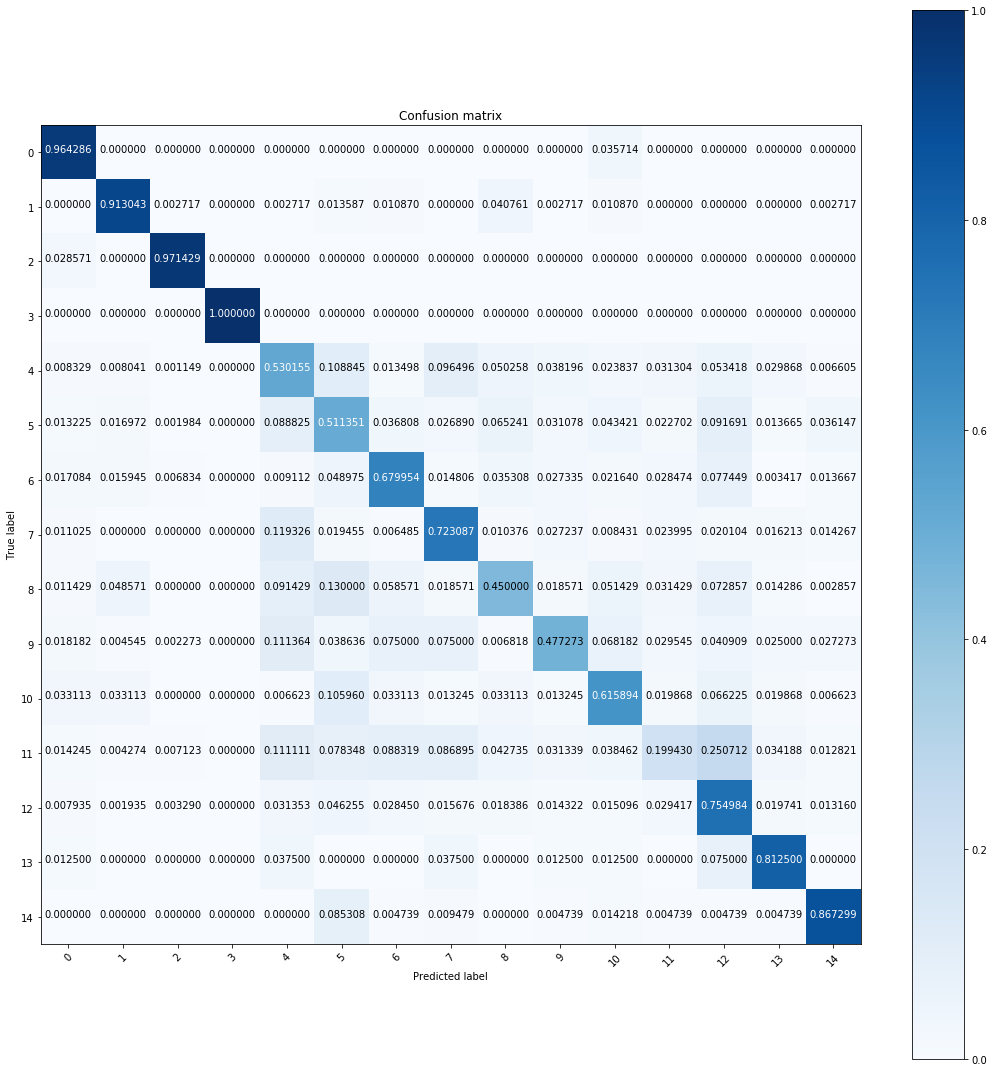

In [183]:
# LogisticRegression
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[0][3][0], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
plt.show()

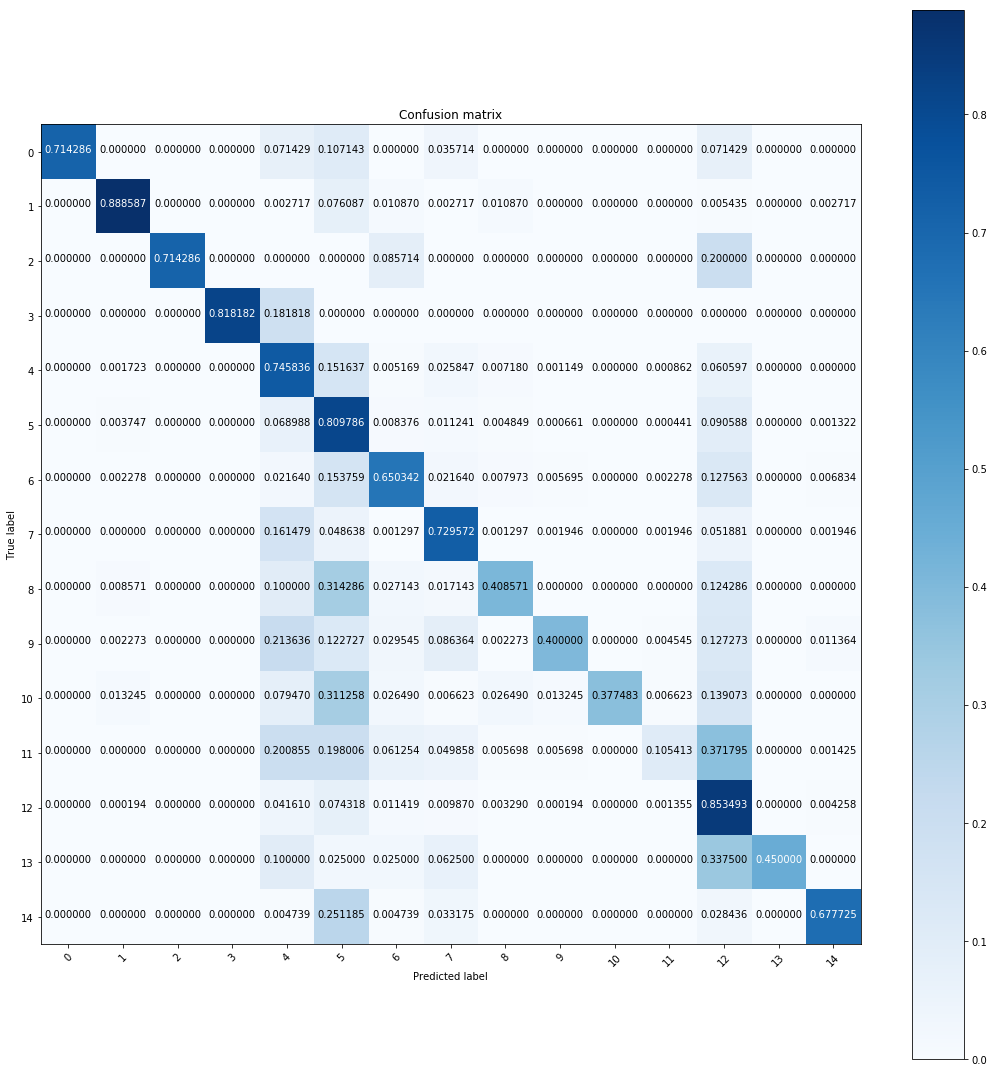

In [184]:
# XGBoost
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[1][3][0], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

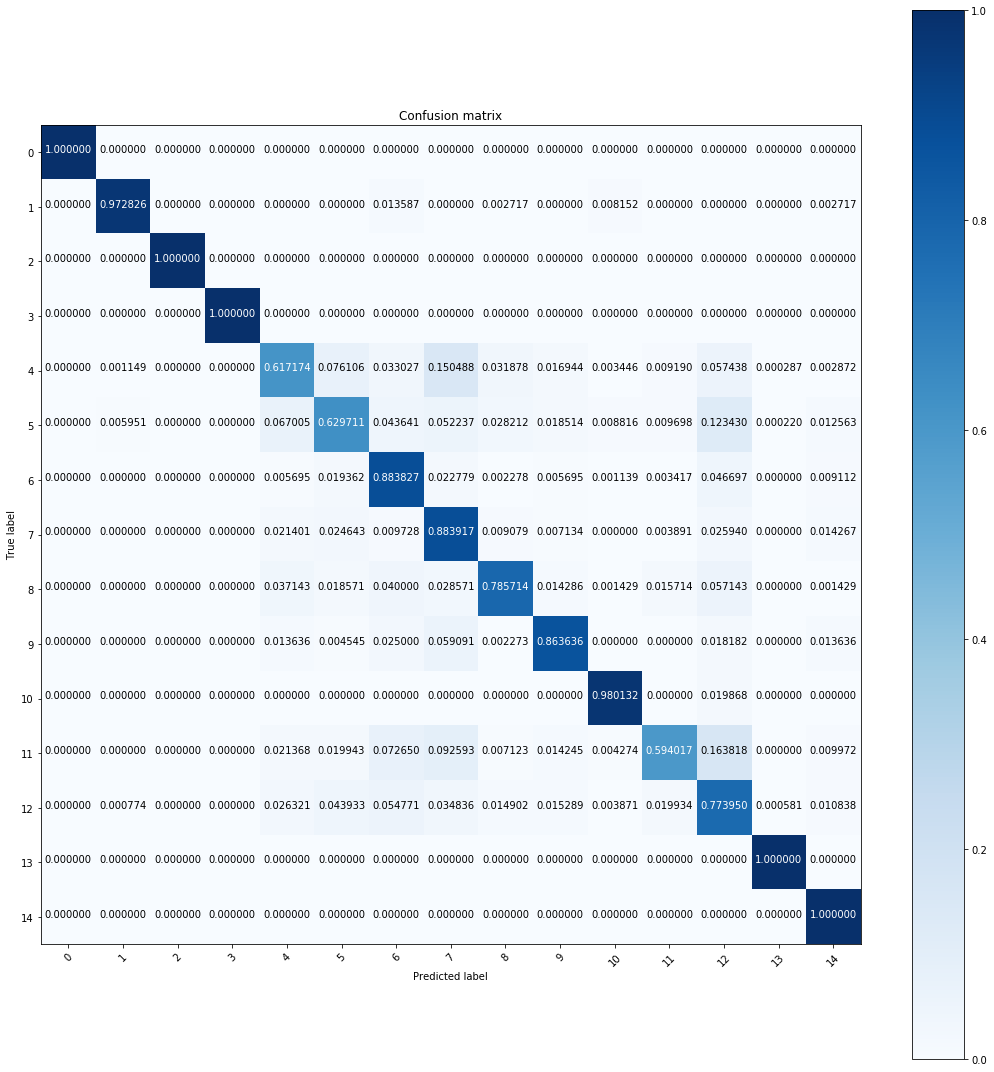

In [185]:
# RandomForest
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[2][3][0], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

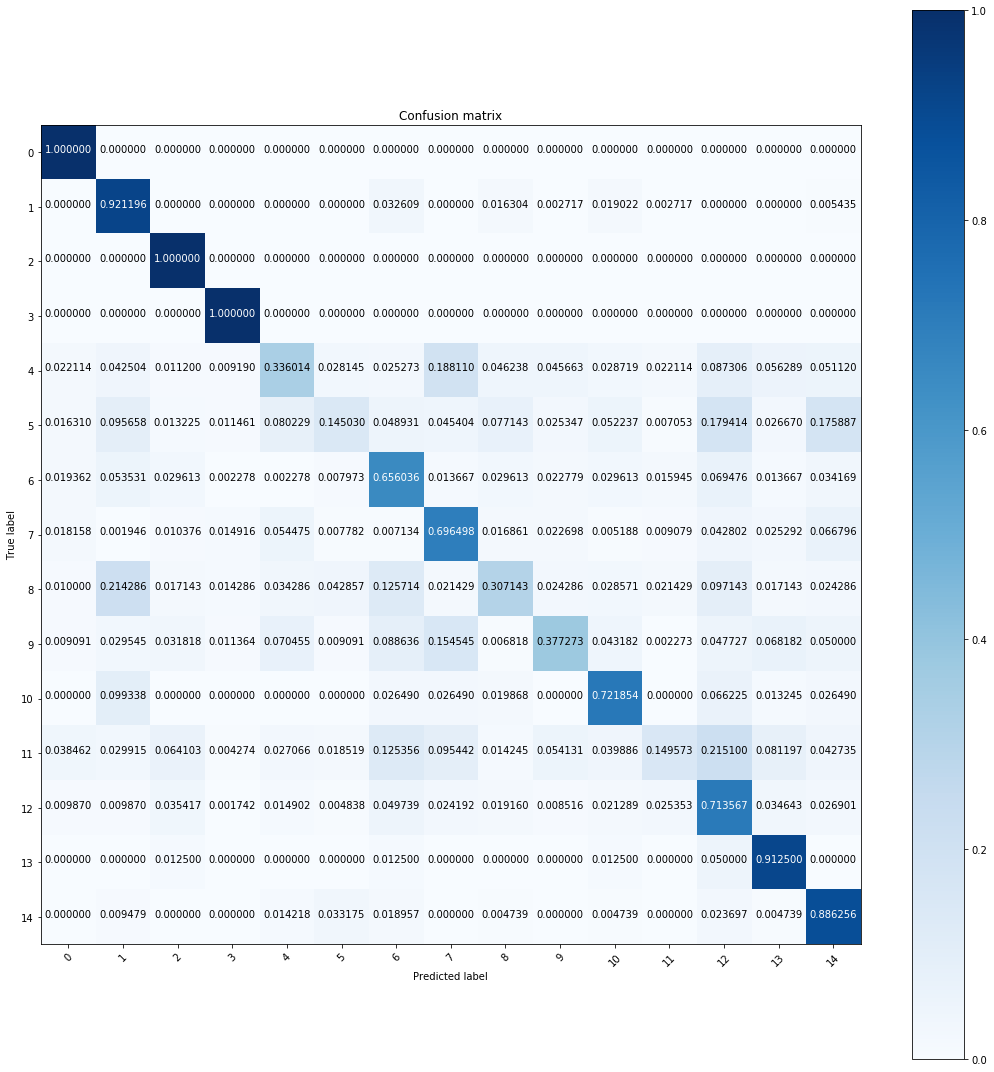

In [196]:
# Bagging
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[3][3][0], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [186]:
restabtest

,f1-score,precision,recall
LogisticRegression,0.600718,0.643871,0.581973
XGBoost,0.649825,0.666412,0.673961
RandomForest,0.568828,0.600008,0.569733
Balance BaggingClassifier,0.434634,0.588333,0.433605


In [187]:
names

[['Blues', 0],
 ['Classical', 1],
 ['Country', 2],
 ['Easy Listening', 3],
 ['Electronic', 4],
 ['Experimental', 5],
 ['Folk', 6],
 ['Hip-Hop', 7],
 ['Instrumental', 8],
 ['International', 9],
 ['Jazz', 10],
 ['Pop', 11],
 ['Rock', 12],
 ['Soul-RnB', 13],
 ['Spoken', 14]]

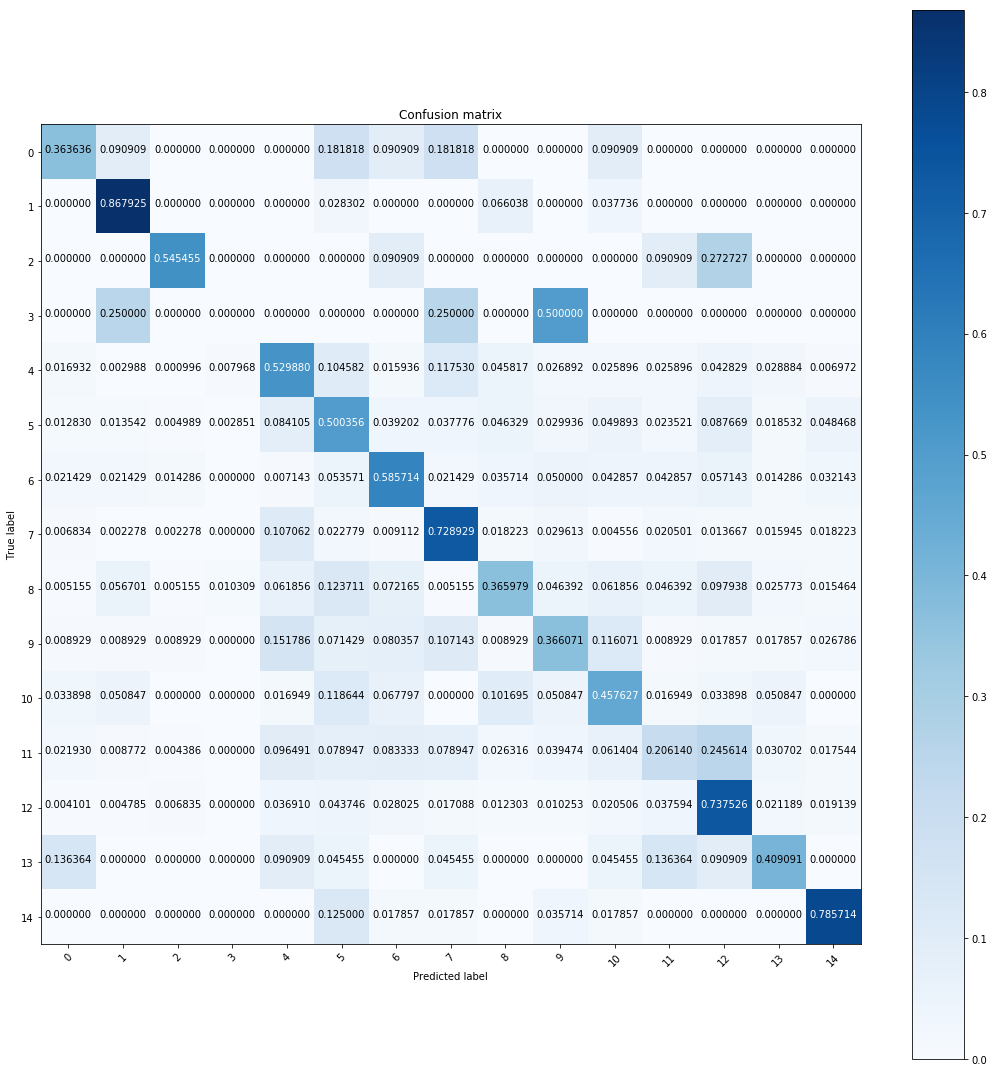

In [188]:
# LogisticRegression
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[0][3][1], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

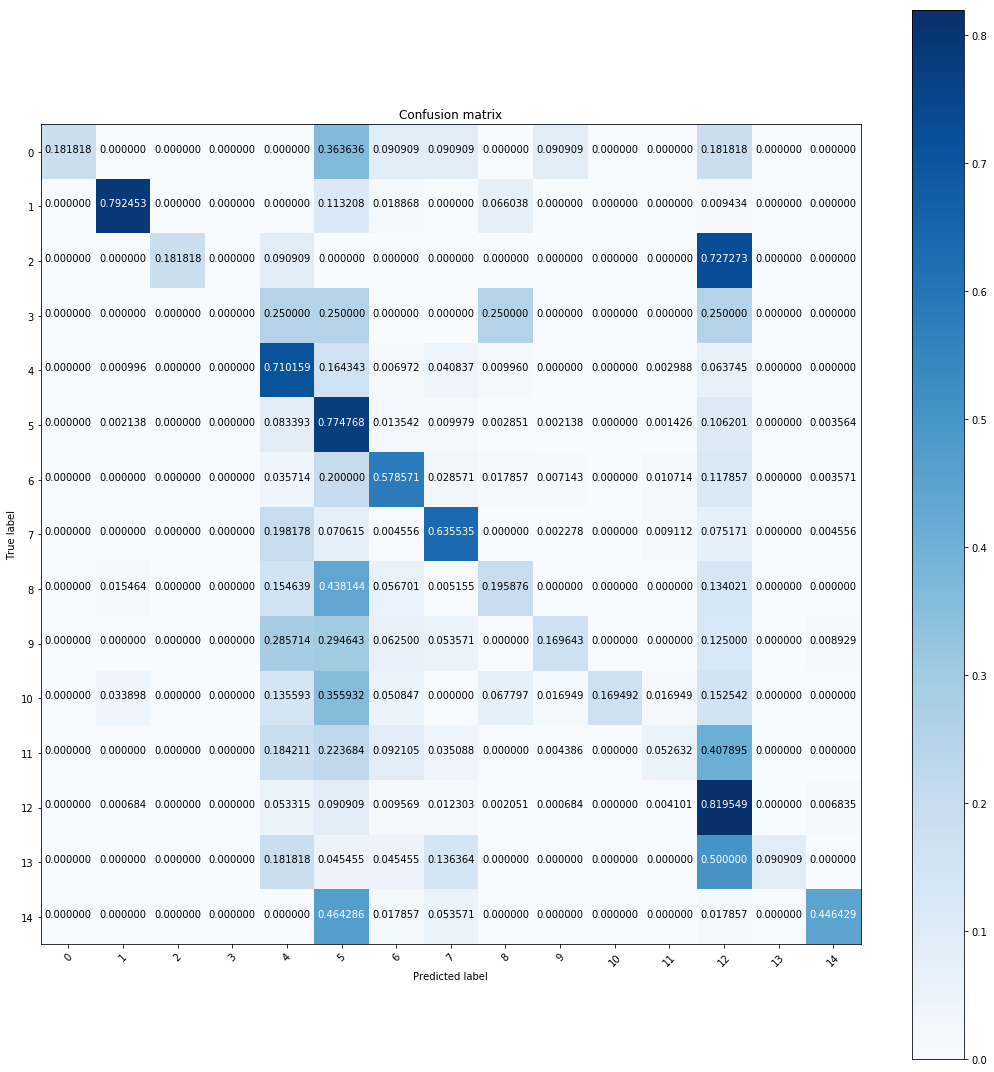

In [189]:
# XGBoost
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[1][3][1], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

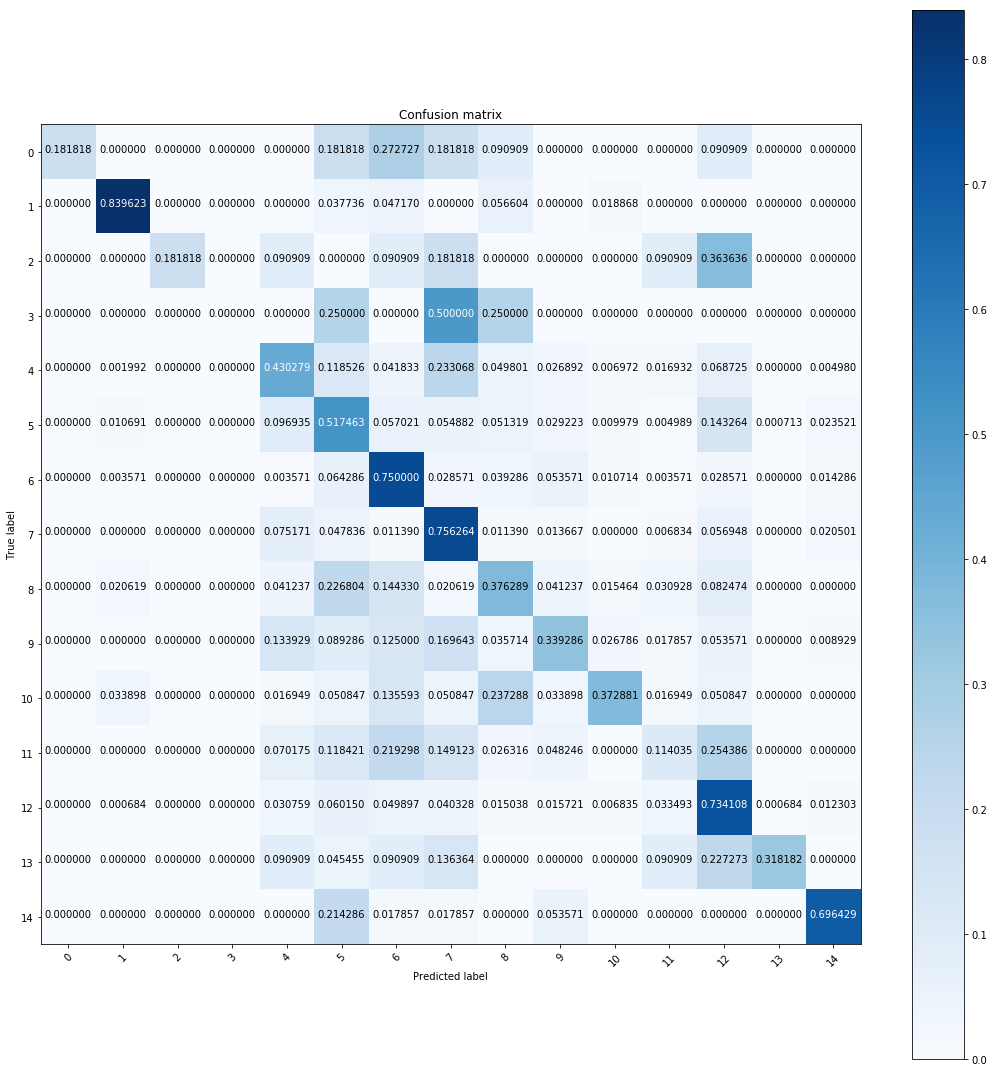

In [190]:
# RandomForest
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[2][3][1], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

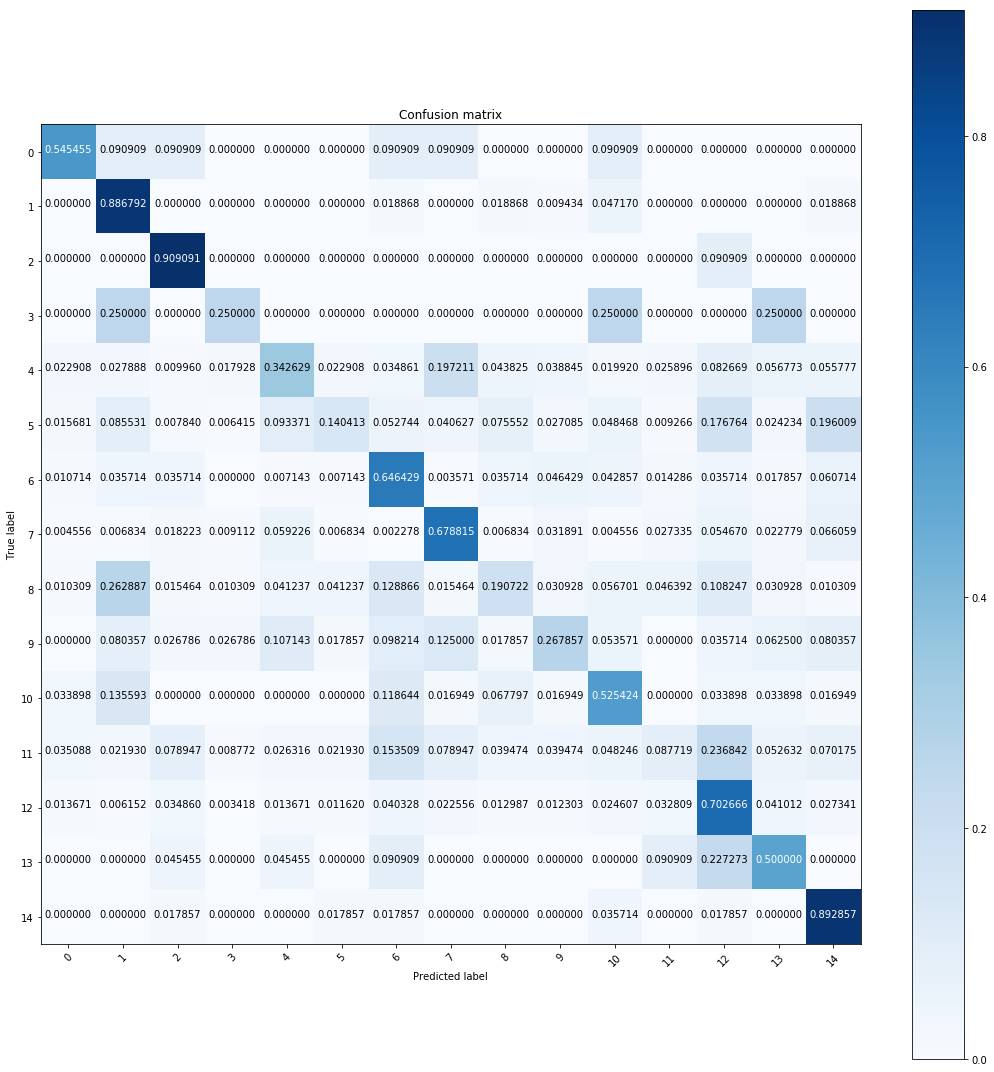

In [197]:
# Bagging
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[3][3][1], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

In [191]:
restabval

,f1-score,precision,recall
LogisticRegression,0.605578,0.649471,0.584672
XGBoost,0.645051,0.659277,0.671508
RandomForest,0.574557,0.599976,0.576638
Balance BaggingClassifier,0.445010,0.593932,0.443449


In [192]:
names

[['Blues', 0],
 ['Classical', 1],
 ['Country', 2],
 ['Easy Listening', 3],
 ['Electronic', 4],
 ['Experimental', 5],
 ['Folk', 6],
 ['Hip-Hop', 7],
 ['Instrumental', 8],
 ['International', 9],
 ['Jazz', 10],
 ['Pop', 11],
 ['Rock', 12],
 ['Soul-RnB', 13],
 ['Spoken', 14]]

In [202]:
y.value_counts()

12    7566
5     6726
4     5095
7     2243
6     1308
11    1065
8     1016
9      629
1      542
14     300
10     249
13     112
2       52
0       41
3       16
Name: track.7, dtype: int64

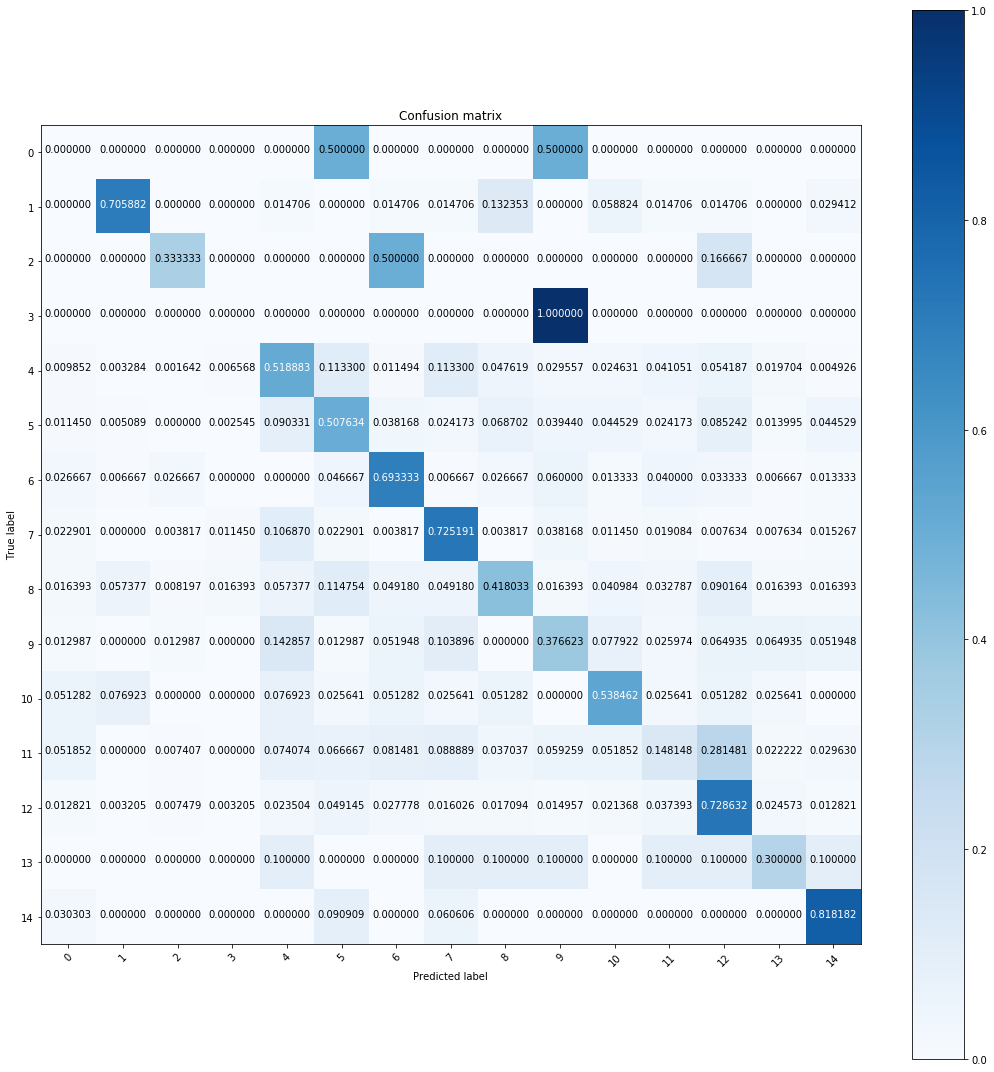

In [193]:
# LogisticRegression
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[0][3][2], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

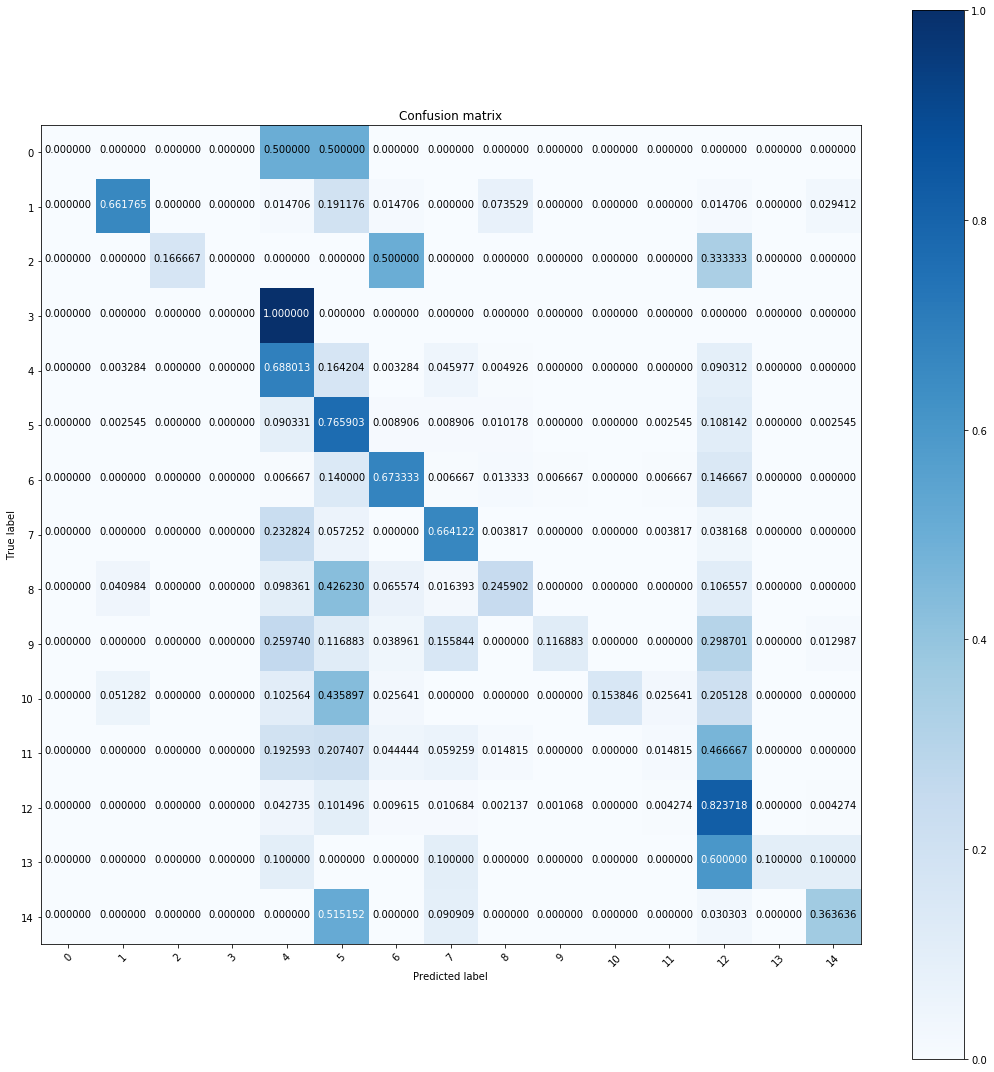

In [194]:
# XGBoost
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[1][3][2], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

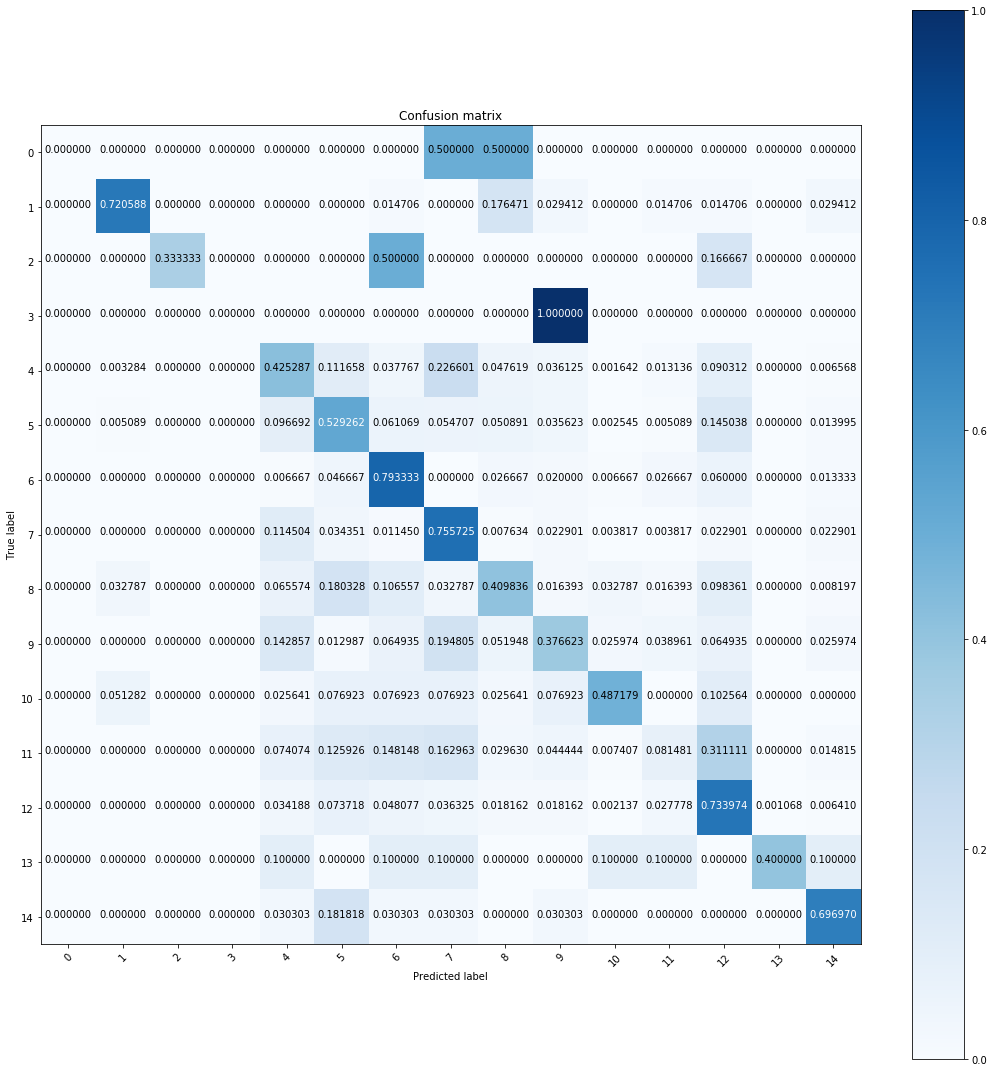

In [195]:
# RandomForest
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[2][3][2], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

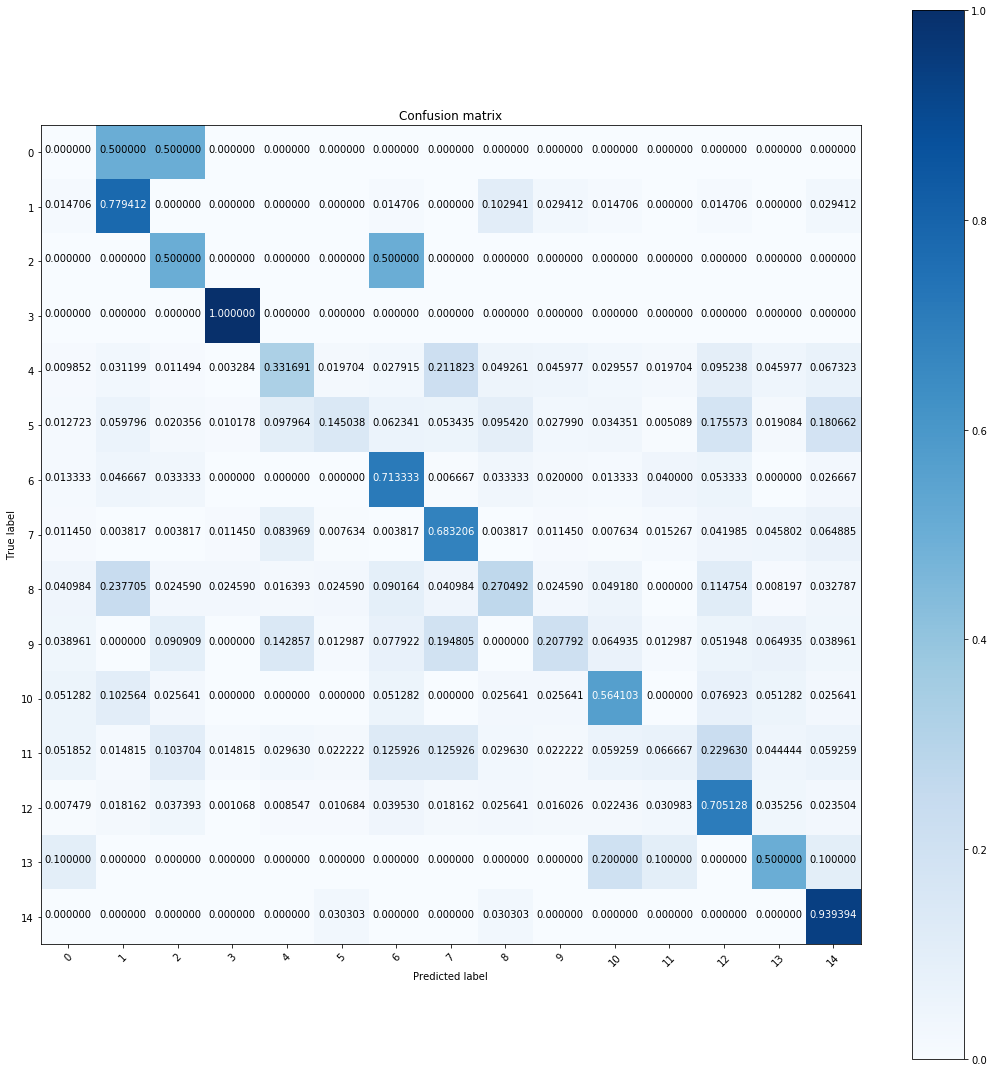

In [198]:
# Bagging
plt.figure(figsize=(15,15))
plot_confusion_matrix(result[3][3][2], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])